### Описание задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

**Описание технологического процесса** 

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).
  
**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

#### Подключение библиотек и загрузка данных

In [1]:
!pip install shap

     |████████████████████████████████| 572 kB 1.3 MB/s eta 0:00:01


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import warnings

from catboost import CatBoostRegressor
from catboost import Pool
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

In [4]:
data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

### Первичное ознакомление с данными

In [5]:
#Создадим словарь. Ключами будут наименования, а значениями переменные с загруженными выборками
dict_data = {'Данные об электродах (data_arc)': data_arc,
             'Данные об объеме подаче сыпучих материалов - объём (data_bulk)': data_bulk, 
             'Данные об объеме подаче сыпучих материалов - время (data_bulk_time)': data_bulk_time,
             'Данные о продувке сплава газом (data_gas)' : data_gas,
             'Результаты измерения температуры (data_temp)' : data_temp,
             'Данные о проволочных материалах - объём (data_wire)' : data_wire,
             'Данные о проволочных материалах - время (data_wire_time)' : data_wire_time
            }

In [6]:
#В цикле выведем первые 5 строк, общую информацию и проверим данные на наличие явных дубликатов и пропусков
for key in dict_data:
    print('\033[1m'+'\033[4m'+key+'\033[0m') #Заголовок сделаем жирным шрифтом с подчеркиванием
    display(dict_data[key].head()) #первые пять строк
    dict_data[key].info() #общая информация
    print()
    print('\033[1m'+'Количество явных дубикатов ='+'\033[0m',dict_data[key].duplicated().sum()) #проверка на наличие явных дубликатов
    print('\033[1m'+'Количество пропусков в столбцах:'+'\033[0m')
    print(dict_data[key].isna().sum()) #проверка на наличие пропусков
    print()

Данные об электродах (data_arc)


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Количество явных дубикатов = 0
Количество пропусков в столбцах:
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Данные об объеме подаче сыпучих материалов - объём (data_bulk)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Количество явных дубикатов = 0
Количество пропусков в столбцах:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB

Количество явных дубикатов = 0
Количество пропусков в столбцах:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     25

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Количество явных дубикатов = 0
Количество пропусков в столбцах:
key      0
Газ 1    0
dtype: int64

Результаты измерения температуры (data_temp)


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB

Количество явных дубикатов = 0
Количество пропусков в столбцах:
key                0
Время замера       0
Температура     3427
dtype: int64

Данные о проволочных материалах - объём (data_wire)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Количество явных дубикатов = 0
Количество пропусков в столбцах:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Данные о проволочных материалах - время (data_wire_time)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Количество явных дубикатов = 0
Количество пропусков в столбцах:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64



При первичном ознакомлении с данными выявлено следующе.
1. набор данных data_arc (Данные об электродах):
- число строк 14876 шт.
- столбцы "Начало нагрева" и "Конец нагрева" содержат данные о дате и времени, но имеют тип object. Необходимо привести к datetime
- явные дубликаты отсутствуют
- пропуски в столбцах отсутствуют
2. набор данных data_bulk (Данные об объеме подаче сыпучих материалов - объём)
- число строк 3129 шт.
- явные дубликаты отсутствуют
- пропуски в столбце "key" отсутствуют, столбцы Bulk 1 - Bulk 15 содержат разное количество пропусков
3. набор данных data_bulk_time (Данные об объеме подаче сыпучих материалов - время)
- число строк 3129 шт, что совпадает с набором данных data_bulk.
- столбцы Bulk 1 - Bulk 15 содержат данные о дате и времени, но имеют тип object. Необходимо привести к datetime
- явные дубликаты отсутствуют
- пропуски в столбце "key" отсутствуют, столбцы Bulk 1 - Bulk 15 содержат разное количество пропусков. Число пропусков в столбцах совпадает с набором данных data_bulk
4. набор данных data_gas (Данные о продувке сплава газом)
- число строк 3239 шт.
- явные дубликаты отсутствуют
- пропуски в данных отсутствуют
5. набор данных data_temp (Результаты измерения температуры)
- число строк 18092 шт.
- столбец "Время замера" имеет тип object, необходимо привести к datetime
- явные дубликаты отсутствуют
- Стобцы "key" и "Время замера" не содержат пропусков. Имеются пропуски в столбце "Температура"
6. набор данных data_wire (Данные о проволочных материалах - объём)
- число строк 3081 шт.
- явные дубликаты отсутствуют
- пропуски в столбце "key" отсутствуют, столбцы Wire 1 - Wire 9 содержат разное количество пропусков
7. набор данных data_wire_time (Данные о проволочных материалах - время)
- число строк 3081 шт.
- данные в столбцах Wire 1 - Wire 9 содержат данные о дате и времени, но имеют тип object. Необходимо привести к datetime
- явные дубликаты отсутствуют
- пропуски в столбце "key" отсутствуют, столбцы Wire 1 - Wire 9 содержат разное количество пропусков. Количество пропусков в столбцах Wire 1 - Wire 9 совпадает с набором данных data_wire.
8. Наборы данных data_bulk, data_bulk_time и data_wire, data_wire_time имеют схожую структуру

### Исследовательский анализ данных

#### Рассмотрим данные об электродах (data_arc)

In [7]:
# Cтатистика для набора данных
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Средняя активная мощность составляет 0.662752 (предположительно, МВт), Средняя реактивная мощность составляет 0.438986 (предположительно, кВар). Имеются значительные отрицательные значения по Реактивной мощности - выброс. Дальнейший анализ целесообразно проводить отбросив отрицательные значения реактивной мощности.

In [8]:
# Преобразуем столбцы с датами в тип datetime
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

# Определим длительность потребления активной и реактивной мощности и преобразуем в секундах
second_hits = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds().astype(int)

In [9]:
second_hits.describe()

count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
dtype: float64

Средняя длительность потребления мощности электродами составляет 171 секунду, минимальное значение - 11 секунд, максимальное значение - 907 секунд.

Визуализируем распределения данных в data_arc (построим гистограммы и боксплоты)

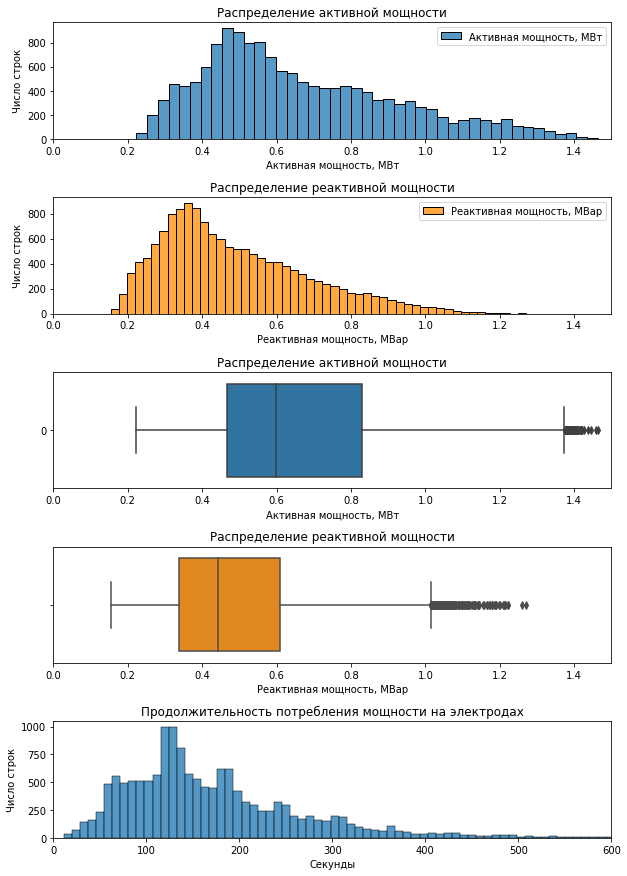

In [10]:
fig, axs = plt.subplots(figsize=[10,15], nrows=5)

sns.histplot(data_arc['Активная мощность'], label = 'Активная мощность, МВт', 
            edgecolor = 'black', ax=axs[0])
axs[0].set_xlabel('Активная мощность, МВт')
axs[0].set_ylabel('Число строк')
axs[0].set_title('Распределение активной мощности')
axs[0].set(xlim=(0, 1.5))
axs[0].legend()

sns.histplot(data_arc['Реактивная мощность'][data_arc['Реактивная мощность'] >= 0],
            label = 'Реактивная мощность, МВар', edgecolor = 'black', ax=axs[1], color='darkorange')
axs[1].set_xlabel('Реактивная мощность, МВар')
axs[1].set_ylabel('Число строк')
axs[1].set_title('Распределение реактивной мощности')
axs[1].set(xlim=(0, 1.5))
axs[1].legend()

sns.boxplot(data=data_arc['Активная мощность'], orient='h', ax=axs[2])
axs[2].set_xlabel('Активная мощность, МВт')
axs[2].set_title('Распределение активной мощности')
axs[2].set(xlim=(0, 1.5))

sns.boxplot(data_arc['Реактивная мощность'][data_arc['Реактивная мощность'] >= 0], orient='h',
            color='darkorange', ax=axs[3])
axs[3].set_xlabel('Реактивная мощность, МВар')
axs[3].set_title('Распределение реактивной мощности')
axs[3].set(xlim=(0, 1.5))

sns.histplot(second_hits, edgecolor = 'black', ax=axs[4])
axs[4].set_xlabel('Секунды')
axs[4].set_ylabel('Число строк')
axs[4].set_title('Продолжительность потребления мощности на электродах')
axs[4].set(xlim=(0, 600))

plt.subplots_adjust(hspace=0.5)


In [11]:
# Вычислим коэффициен корреляции между столбцами
correlation = data_arc['Активная мощность'].corr(data_arc['Реактивная мощность']\
                                                 [data_arc['Реактивная мощность'] >= 0])

print('Коэффициент корреляции =', correlation)

Коэффициент корреляции = 0.9663734456187295


Существует сильная линейная зависимость между активной и реактивной мощностью. Для Устранения мультиколлинеарности признаков имеет смысл объединить столбцы Активная мощность и Реактивная мощность в столбец "Полная мощность". Для этого необходио сложить квадраты значений активной и реактивной мощности

#### Данные об объеме подаче сыпучих материалов - объём (data_bulk)

In [12]:
# статистика для набора данных
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Визуализируем распределения данных в data_bulk (построим гистограммы и боксплоты)

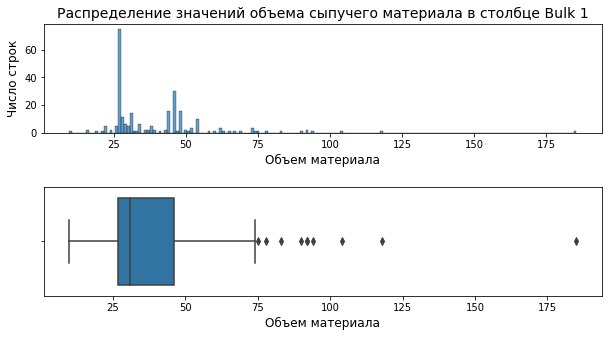

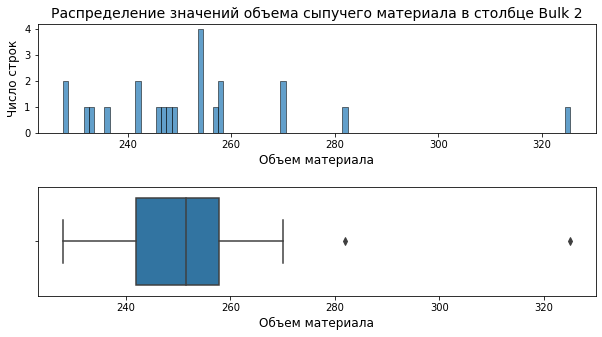

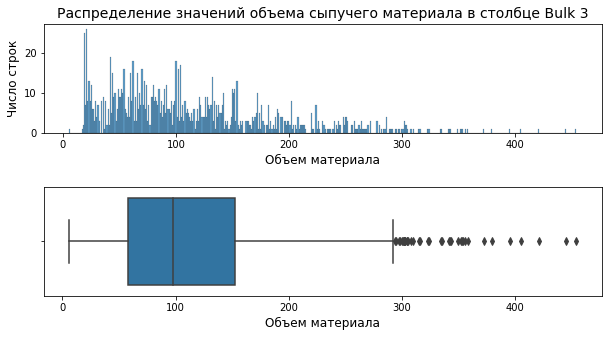

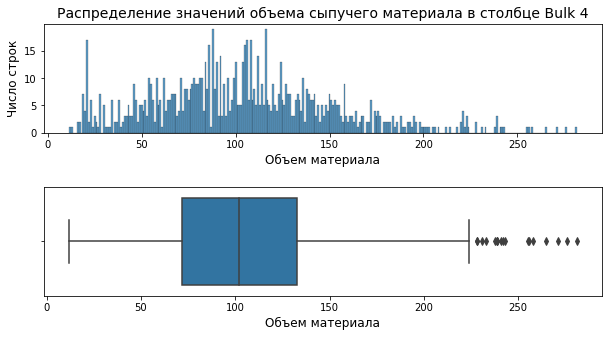

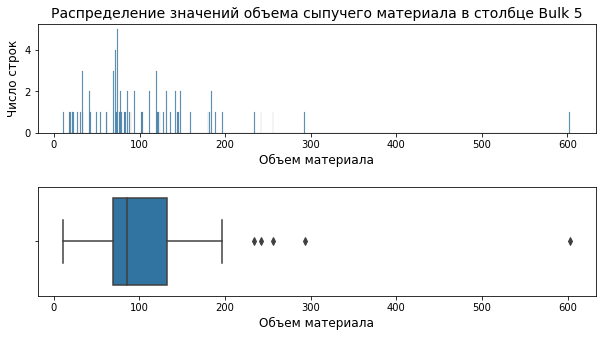

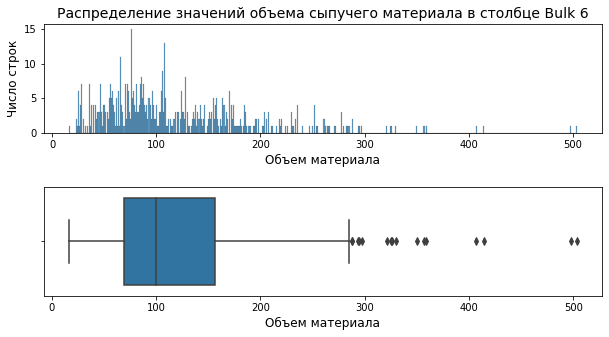

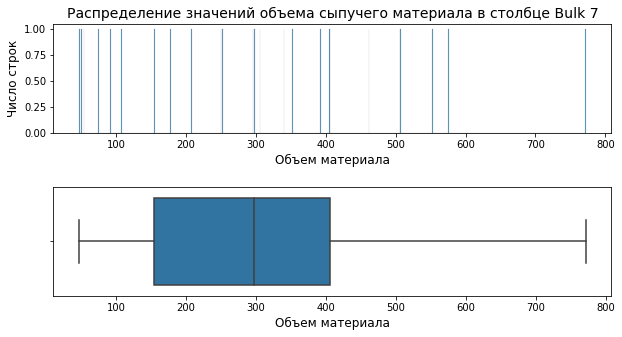

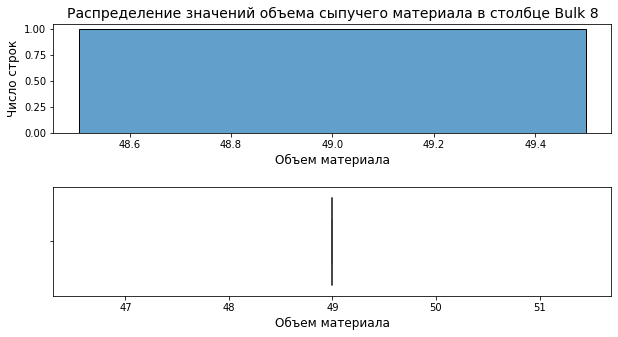

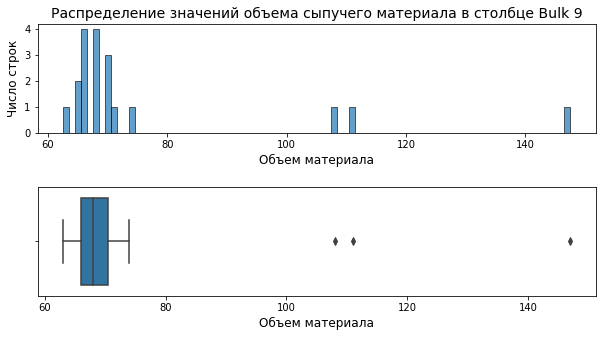

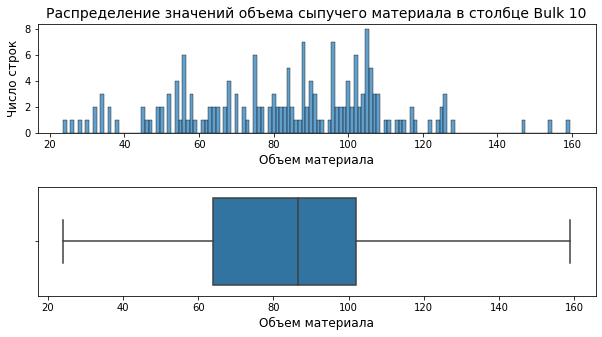

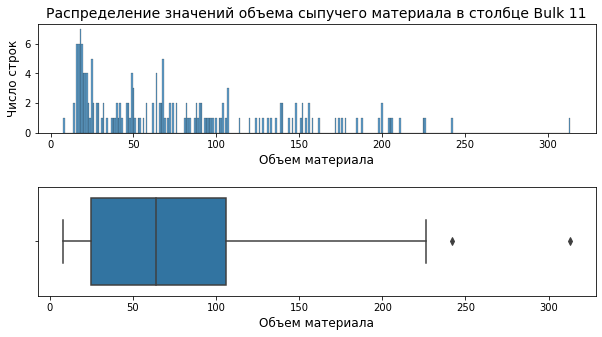

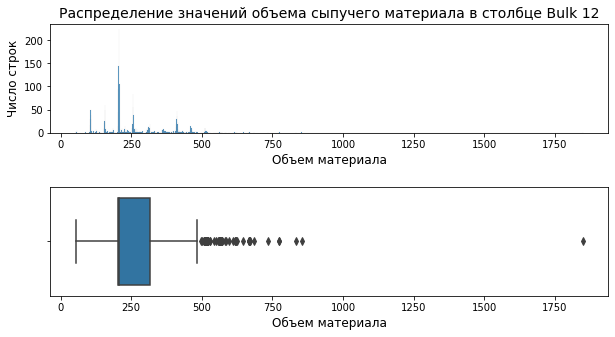

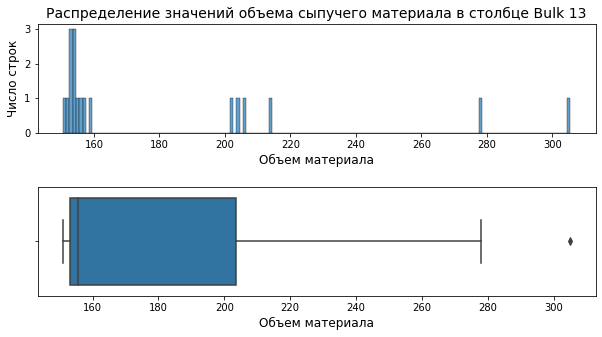

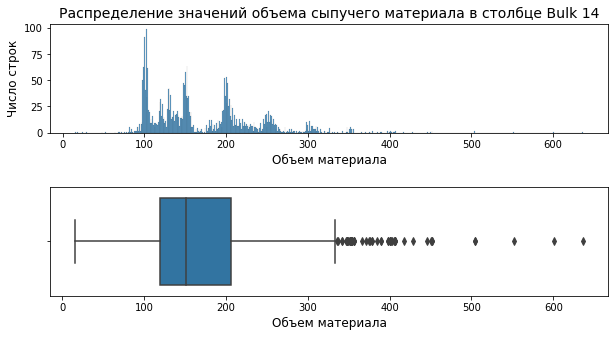

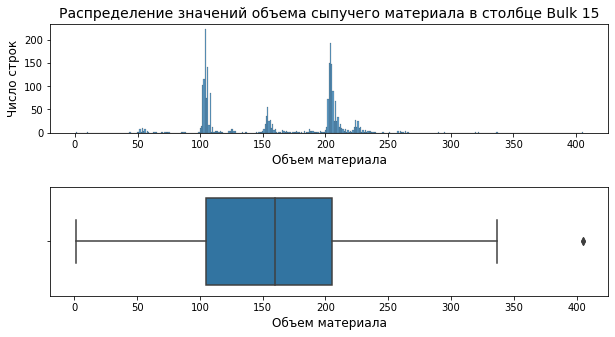

In [13]:
columns_bulks = data_bulk.columns.to_list()[1:]

for column in columns_bulks:
    fig, axs = plt.subplots(figsize=[10,5], nrows=2)
    sns.histplot(data=data_bulk, x=column, alpha=.7, edgecolor = 'black', discrete=True, ax=axs[0])
    axs[0].set_xlabel('Объем материала', size=12)
    axs[0].set_ylabel('Число строк', size=12)
    axs[0].set_title(f'Распределение значений объема сыпучего материала в столбце {column}', size=14)
    
    sns.boxplot(data=data_bulk, x=column, orient='h', ax=axs[1])
    axs[1].set_xlabel('Объем материала', size=12)
    plt.subplots_adjust(hspace=0.5)
    plt.show()

Выход значений за межквартильный размах не характеризует значение, как выброс. Причиной, вероятнее всего является редкость применения такой лигирующей добавки. Из анализа статистики и графиков видно, что значение объема сыпучего материала в столбце 'bulk 8' встречаются в наборе данных однократно и равно 49.

Реже всего применяются сыпучие материалы:
- Bulk 8 - 1 раз;
- Bulk 13 - 18 раз;
- Bulk 9 - 19 раз;
- Bulk 2 - 22 раза;
- Bulk 7 - 25 раз;
- Bulk 5 - 77 раз;

#### Данные об объеме подаче сыпучих материалов - время (data_bulk_time)

Визуализируем данные о времени подаче сыпучих материалов (лигирующих добавках), построим гистограммы подачи сыпучих материалов по датам. Для этого приведем значения в столбцах к формату datetime 

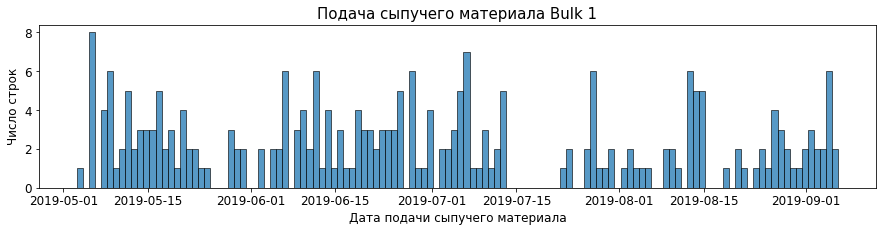

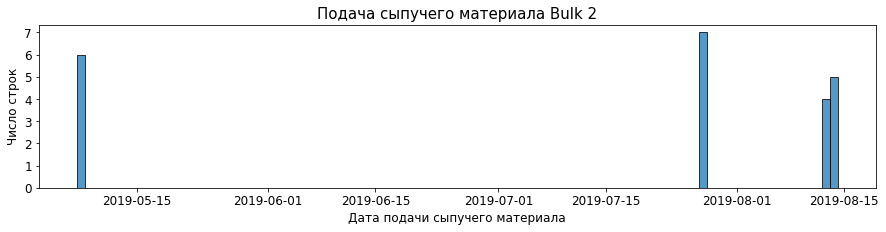

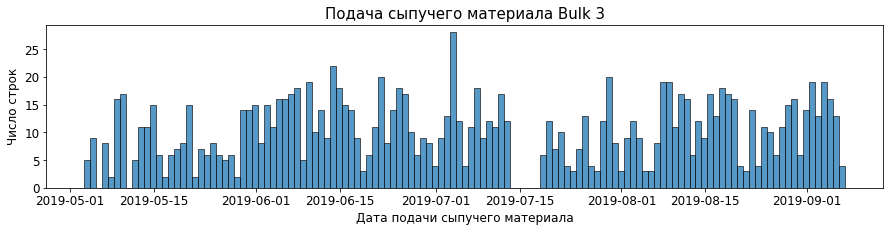

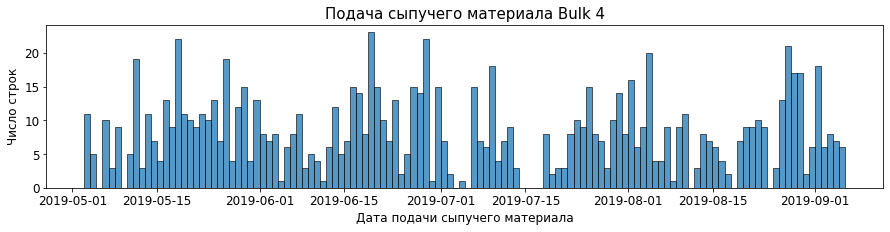

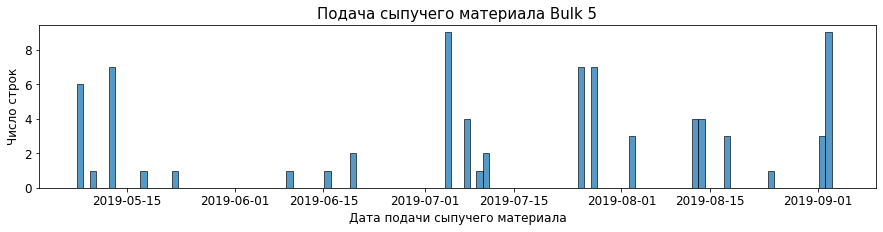

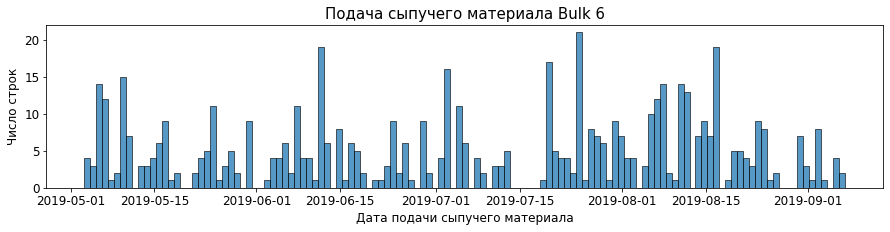

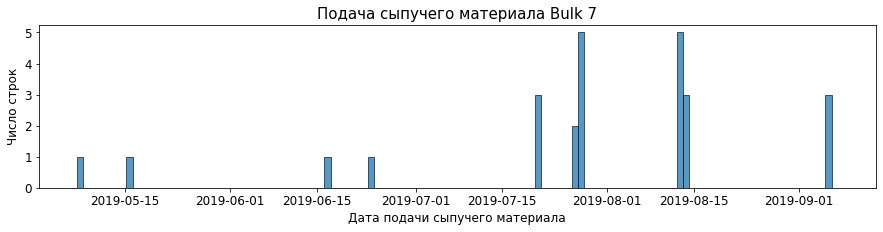

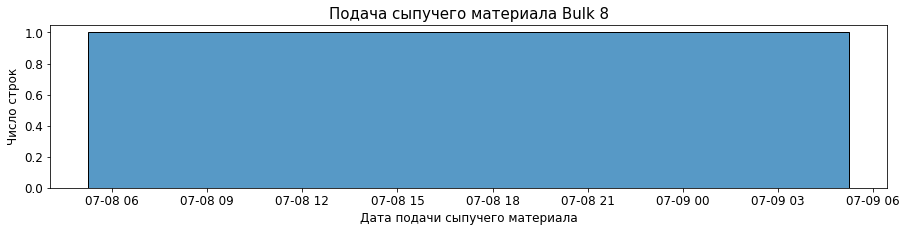

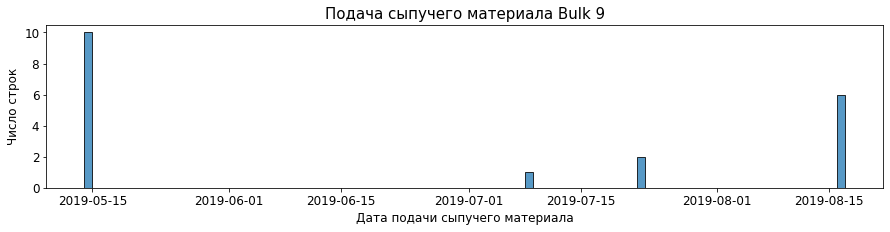

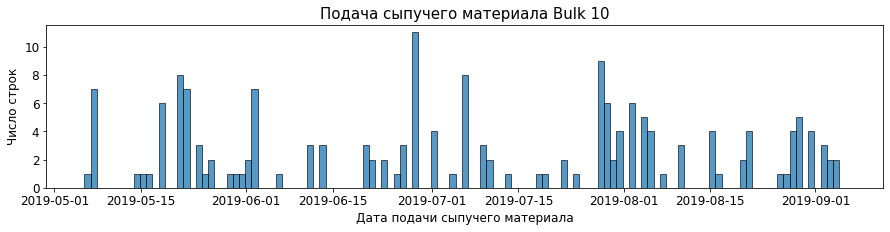

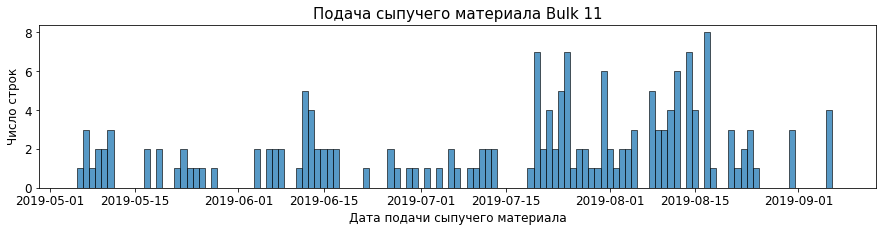

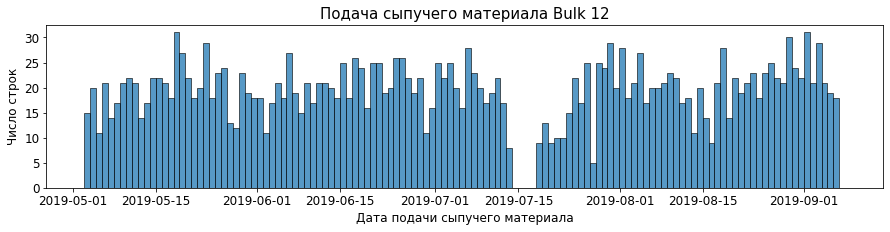

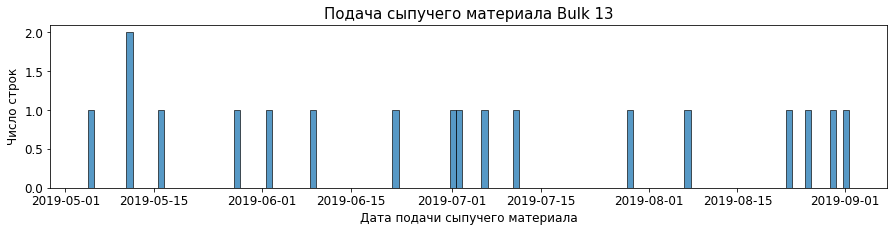

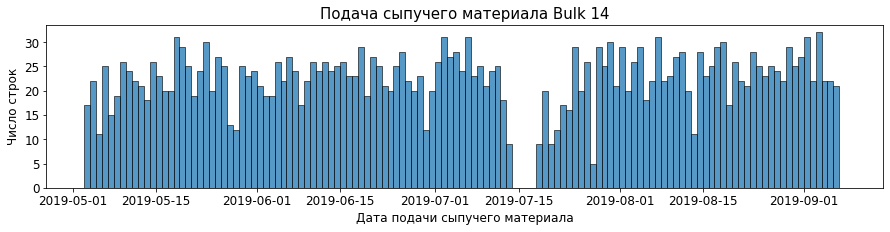

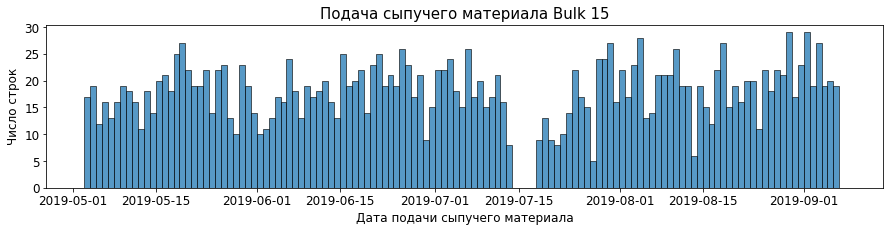

In [14]:
columns_bulks_time = data_bulk_time.columns.to_list()[1:]

for column in columns_bulks_time:
    plt.figure(figsize=[15,3])

    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column])
    
    sns.histplot(data=data_bulk_time, x=column, edgecolor = 'black', discrete=True)

    plt.xlabel('Дата подачи сыпучего материала', size = 12)
    plt.ylabel('Число строк', size = 12)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.title(f'Подача сыпучего материала {column}', size = 15)

    plt.show()
 

Полученные гистограммы дополняют информацию, содержащуюся в наборе данных data_bulk. В данном наборе данных содержится информация о датах использования лигирующих добавок.
Значения в столбце Bulk 8 отличаются от даты. Вероятнее всего в этом столбце находится время подачи сыпучего материала. Данное значение единственное.

Необходимо уточнить назначение столбца Bulk 8, каким образом значения в данном столбце влияют на технологический процесс?

#### Данные о продувке сплава газом (data_gas)

In [15]:
# Статистика для набора данных
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Визуализируем данные по продувке сплава газом, для этого построим гистограмму распределения значений

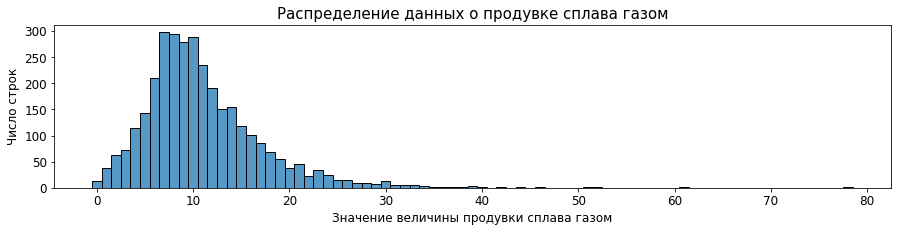

In [16]:
plt.figure(figsize=[15,3])

sns.histplot(data=data_gas['Газ 1'], edgecolor = 'black', discrete=True)

plt.xlabel('Значение величины продувки сплава газом', size = 12)
plt.ylabel('Число строк', size = 12)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title('Распределение данных о продувке сплава газом', size = 15)

plt.show()

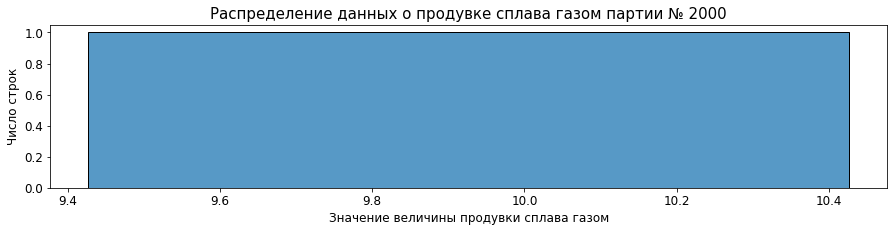

In [17]:

plt.figure(figsize=[15,3])
part = 2000 #номер партии

sns.histplot(data=data_gas[data_gas['key'] == part]['Газ 1'], edgecolor = 'black', discrete=True)

plt.xlabel('Значение величины продувки сплава газом', size = 12)
plt.ylabel('Число строк', size = 12)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title(f'Распределение данных о продувке сплава газом партии № {part}', size = 15)

plt.show()

In [18]:
# Количество партий с подачей газа больше 50
print('Число партий с подачей газа больше 50 =', len(data_gas[data_gas['Газ 1'] > 50]['key']))

Число партий с подачей газа больше 50 = 5


Возможно имеются аномалии в данных по партиям с подачей газа больще 50. Продувка сплава газом в партии №1000 постоянна 

#### Результаты измерения температуры (data_temp)

In [19]:
# Статистика для набора данных
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [20]:
# Число уникальных значений партий 
data_temp['key'].nunique()

3216

Визуализируем данные по измерению температуры, для этого построим гистограмму распределения значений

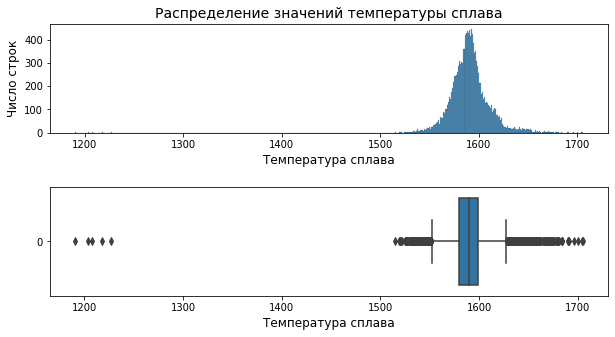

In [21]:
fig, axs = plt.subplots(figsize=[10,5], nrows=2)

sns.histplot(data=data_temp['Температура'], edgecolor = 'black', discrete=True, ax=axs[0])
axs[0].set_xlabel('Температура сплава', size=12)
axs[0].set_ylabel('Число строк', size=12)
axs[0].set_title(f'Распределение значений температуры сплава', size=14)

sns.boxplot(data=data_temp['Температура'], orient='h', ax=axs[1])
axs[1].set_xlabel('Температура сплава', size=12)
plt.subplots_adjust(hspace=0.5)

plt.show()

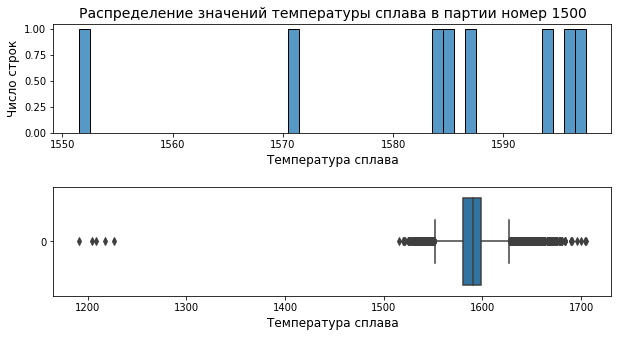

In [22]:
fig, axs = plt.subplots(figsize=[10,5], nrows=2)
part = 1500 # Номер партии для которой рассмотрим распределение температуры

sns.histplot(data=data_temp[data_temp['key'] == part]['Температура'], edgecolor = 'black', discrete=True, ax=axs[0])
axs[0].set_xlabel('Температура сплава', size=12)
axs[0].set_ylabel('Число строк', size=12)
axs[0].set_title(f'Распределение значений температуры сплава в партии номер {part}', size=14)

sns.boxplot(data=data_temp['Температура'], orient='h', ax=axs[1])
axs[1].set_xlabel('Температура сплава', size=12)
plt.subplots_adjust(hspace=0.5)

plt.show()

Имеются данные с пониженной температурой сплава (около 1200  градусов) относительно медианного значения - 1600 градусов. Перед проведением предобработки необходимо уточнить, являются ли данные значения выбросами или нет

#### Данные о проволочных материалах - объём (data_wire)

In [23]:
# Статистика для набора данных
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Визуализируем данные. Построим гистограммы распределения значений для объема проволочных материалов и боксплоты

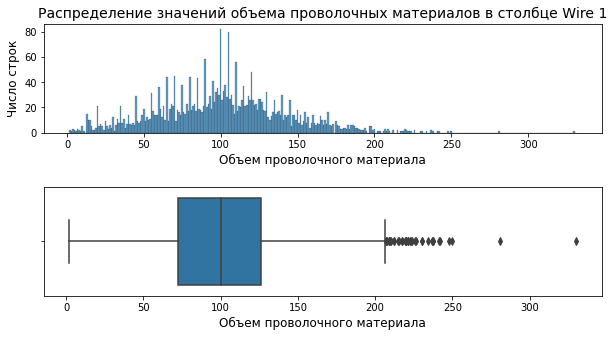

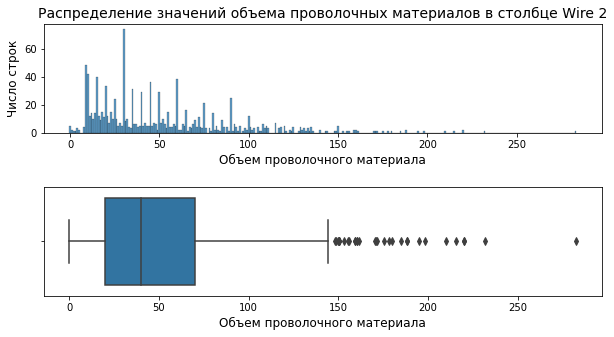

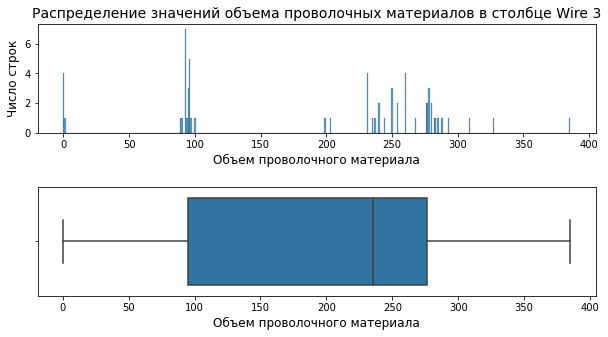

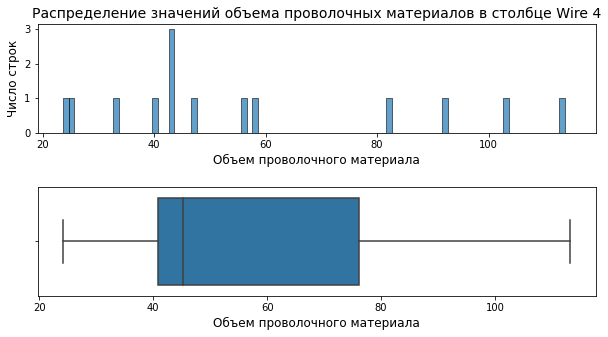

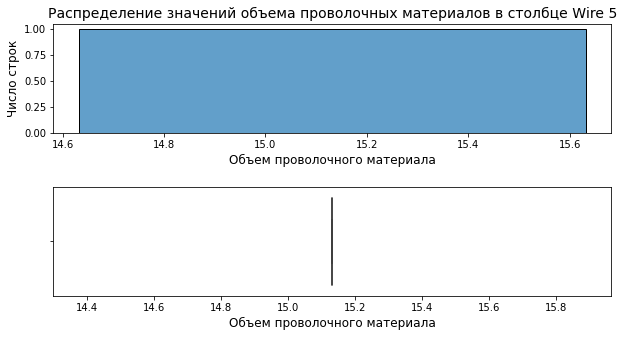

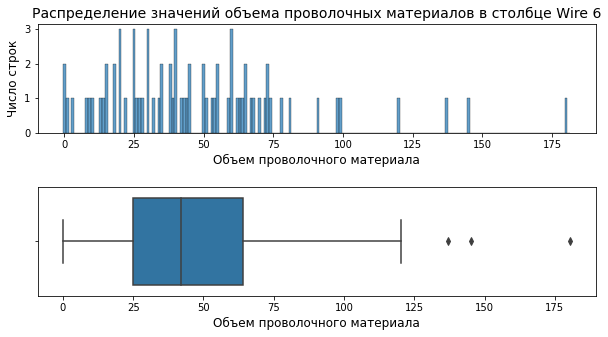

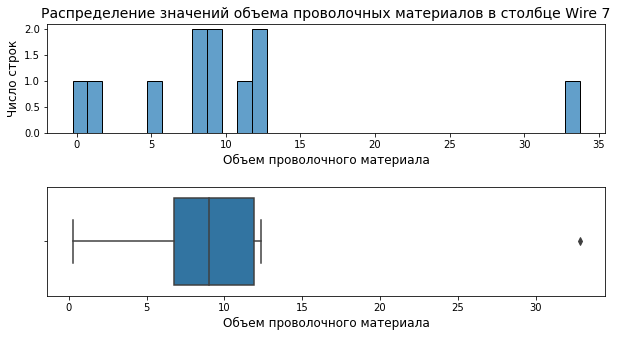

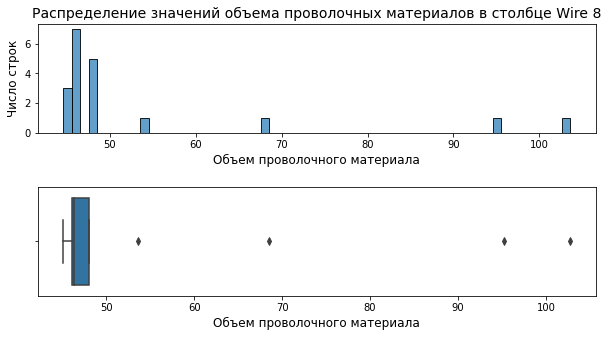

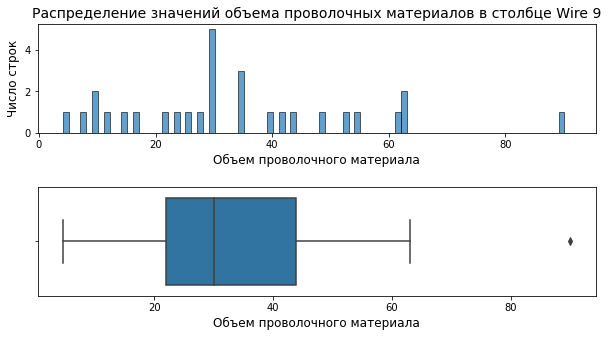

In [24]:
columns_wire = data_wire.columns.to_list()[1:]

for column in columns_wire:
    fig, axs = plt.subplots(figsize=[10,5], nrows=2)
    sns.histplot(data=data_wire, x=column, alpha=.7, edgecolor = 'black', discrete=True, ax=axs[0])
    axs[0].set_xlabel('Объем проволочного материала', size=12)
    axs[0].set_ylabel('Число строк', size=12)
    axs[0].set_title(f'Распределение значений объема проволочных материалов в столбце {column}', size=14)
    
    sns.boxplot(data=data_wire, x=column, orient='h', ax=axs[1])
    axs[1].set_xlabel('Объем проволочного материала', size=12)
    plt.subplots_adjust(hspace=0.5)
    plt.show()

Вданном случая, выход значений за межквартильный размах не характеризует значение, как выброс. Причиной, вероятнее всего является редкость применения определенного проволочного материала в технологическом процессе. Из анализа статистики и графиков видно, что значение объема проволочного материала в столбце 'Wire 5' встречаются в наборе данных однократно и равно 15.132

Реже всего применяются проволочные материалы:
- Wire 5 - 1 раз;
- Wire 7 - 11 раз;
- Wire 4 - 14 раз;
- Wire 9 - 29 раз;
- Wire 3 - 63 раз;
- Wire 5 - 73 раза.

Наиболее частыми являются добавки проволочных материалов Wire 1 - 3055 раз, Wire 2 - 1079 раз.  
Структура набора данных по объему проволочных материалов схожа с наборами данных о сыпучих материалах

#### Данные о проволочных материалах - время (data_wire_time)

Визуализируем данные об использовании проволочных материалов, построим гистограммы подачи проволочных материалов по датам. Для этого приведем значения в столбцах к формату datetime 

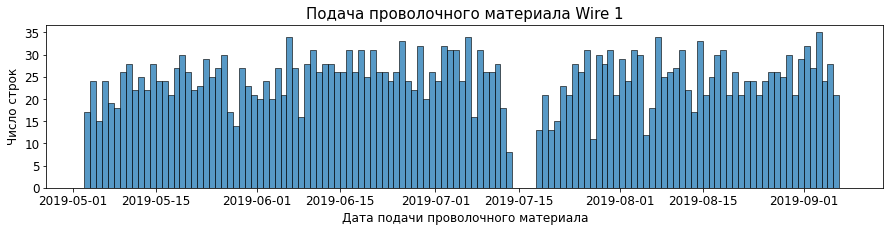

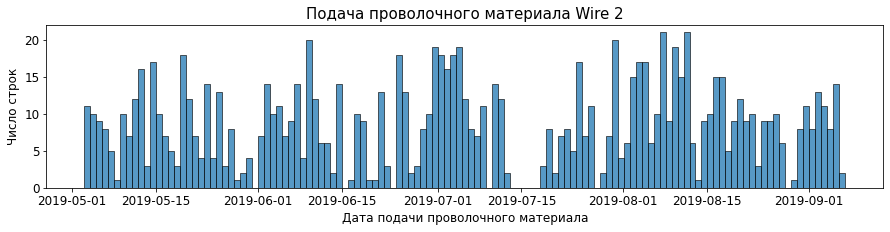

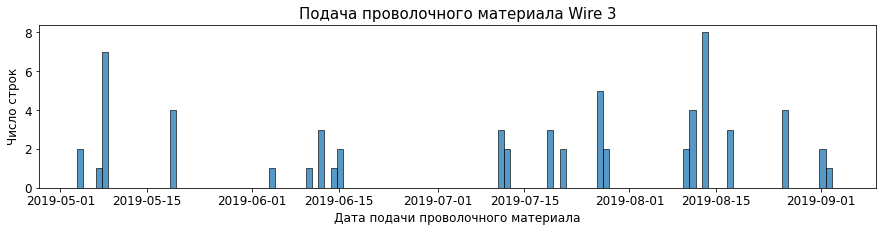

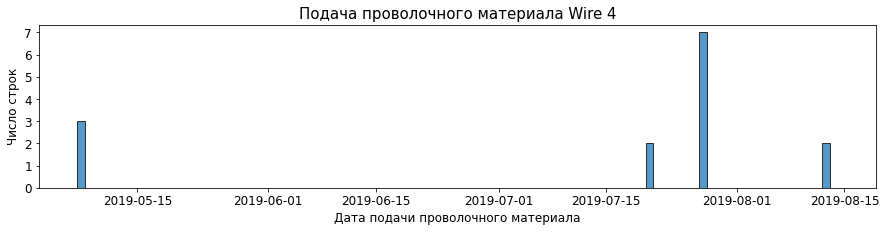

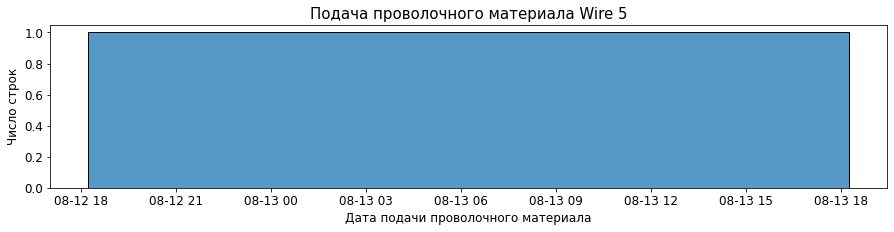

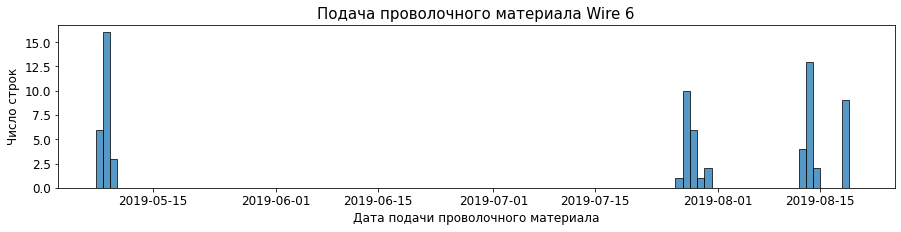

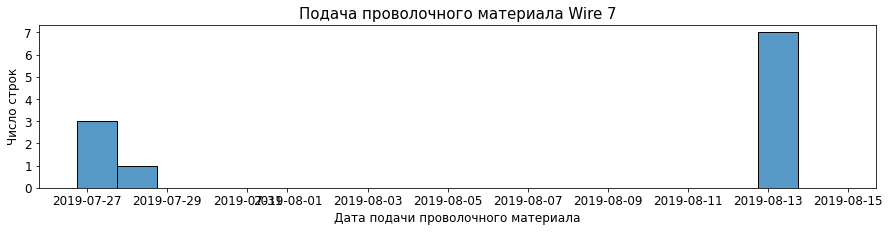

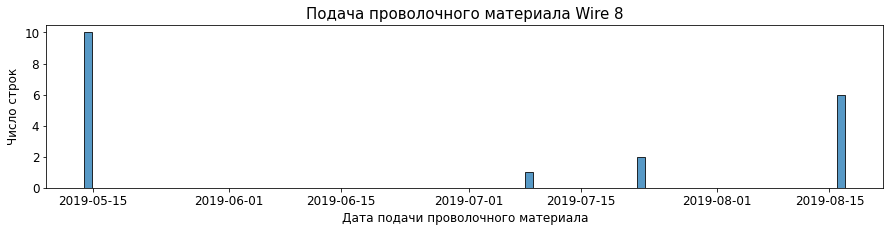

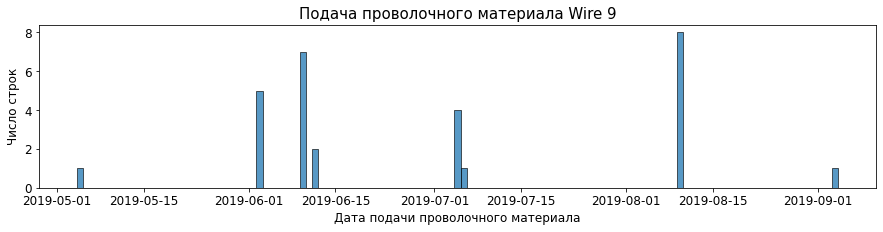

In [25]:
columns_wire_time = data_wire_time.columns.to_list()[1:]

for column in columns_wire_time:
    plt.figure(figsize=[15,3])

    data_wire_time[column] = pd.to_datetime(data_wire_time[column])
    
    sns.histplot(data=data_wire_time, x=column, edgecolor = 'black', discrete=True)

    plt.xlabel('Дата подачи проволочного материала', size = 12)
    plt.ylabel('Число строк', size = 12)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.title(f'Подача проволочного материала {column}', size = 15)

    plt.show()

Полученные гистограммы дополняют информацию, содержащуюся в наборе данных data_wire. В данном наборе данных содержится информация о датах использования проволочного материала.
Значения в столбце Wire 5 отличаются от даты. Вероятнее всего в этом столбце находится время материала. Данное значение единственное.

Необходимо уточнить назначение столбца Wire 5, каким образом значения в данном столбце влияют на технологический процесс?

#### Вывод по первичному ознакомлению с данными и исследовательскому анализу

При первичном ознакомлении с данными выявлено следующе.
1. набор данных data_arc (Данные об электродах):
- число строк 14876 шт.
- столбцы "Начало нагрева" и "Конец нагрева" содержат данные о дате и времени, но имеют тип object. Необходимо привести к datetime
- явные дубликаты отсутствуют
- пропуски в столбцах отсутствуют
2. набор данных data_bulk (Данные об объеме подаче сыпучих материалов - объём)
- число строк 3129 шт.
- явные дубликаты отсутствуют
- пропуски в столбце "key" отсутствуют, столбцы Bulk 1 - Bulk 15 содержат разное количество пропусков
3. набор данных data_bulk_time (Данные об объеме подаче сыпучих материалов - время)
- число строк 3129 шт, что совпадает с набором данных data_bulk.
- столбцы Bulk 1 - Bulk 15 содержат данные о дате и времени, но имеют тип object. Необходимо привести к datetime
- явные дубликаты отсутствуют
- пропуски в столбце "key" отсутствуют, столбцы Bulk 1 - Bulk 15 содержат разное количество пропусков. Число пропусков в столбцах совпадает с набором данных data_bulk
4. набор данных data_gas (Данные о продувке сплава газом)
- число строк 3239 шт.
- явные дубликаты отсутствуют
- пропуски в данных отсутствуют
5. набор данных data_temp (Результаты измерения температуры)
- число строк 18092 шт.
- столбец "Время замера" имеет тип object, необходимо привести к datetime
- явные дубликаты отсутствуют
- Стобцы "key" и "Время замера" не содержат пропусков. Имеются пропуски в столбце "Температура"
6. набор данных data_wire (Данные о проволочных материалах - объём)
- число строк 3081 шт.
- явные дубликаты отсутствуют
- пропуски в столбце "key" отсутствуют, столбцы Wire 1 - Wire 9 содержат разное количество пропусков
7. набор данных data_wire_time (Данные о проволочных материалах - время)
- число строк 3081 шт.
- данные в столбцах Wire 1 - Wire 9 содержат данные о дате и времени, но имеют тип object. Необходимо привести к datetime
- явные дубликаты отсутствуют
- пропуски в столбце "key" отсутствуют, столбцы Wire 1 - Wire 9 содержат разное количество пропусков. Количество пропусков в столбцах Wire 1 - Wire 9 совпадает с набором данных data_wire.
8. Наборы данных data_bulk, data_bulk_time и data_wire, data_wire_time имеют схожую структуру.

В результате исследовательского анализа установлено следующее.  
1. Средняя активная мощность подаваемая на электроды составляет 0.662752 (предположительно, МВт), Средняя реактивная мощность составляет 0.438986 (предположительно, кВар). Имеются значительные отрицательные значения по Реактивной мощности - выброс. Необходимо удалить строки с отрицательными значениями реактивной мощности.
2. Средняя длительность потребления мощности электродами составляет 171 секунду, минимальное значение - 11 секунд, максимальное значение - 907 секунд.
3. Существует сильная линейная зависимость между активной и реактивной мощностью. Для Устранения мультиколлинеарности признаков имеет смысл объединить столбцы Активная мощность и Реактивная мощность в столбец "Полная мощность". Для этого необходио сложить квадраты значений активной и реактивной мощности.
4. значение объема сыпучего материала в столбце 'bulk 8' встречаются в наборе данных data_bulk однократно и равно 49.
Реже всего применяются сыпучие материалы:
- Bulk 8 - 1 раз;
- Bulk 13 - 18 раз;
- Bulk 9 - 19 раз;
- Bulk 2 - 22 раза;
- Bulk 7 - 25 раз;
- Bulk 5 - 77 раз.
5. Полученные гистограммы для набора данных data_bulk_time дополняют информацию, содержащуюся в наборе данных data_bulk. В данном наборе данных содержится информация о датах использования лигирующих добавок.
Значения в столбце Bulk 8 отличаются от даты. Вероятнее всего в этом столбце находится время подачи сыпучего материала. Данное значение единственное. Необходимо уточнить назначение столбца Bulk 8, каким образом значения в данном столбце влияют на технологический процесс?
6. В data_temp содержаться данные с пониженной температурой сплава (около 1200  градусов) относительно медианного значения - 1600 градусов. Перед проведением предобработки необходимо уточнить, являются ли данные значения выбросами или нет?
7. Значение объема проволочного материала в столбце 'Wire 5' в data_wire встречаются в наборе данных однократно и равно 15.132
Реже всего применяются проволочные материалы:
- Wire 5 - 1 раз;
- Wire 7 - 11 раз;
- Wire 4 - 14 раз;
- Wire 9 - 29 раз;
- Wire 3 - 63 раз;
- Wire 5 - 73 раза.  
Наиболее частыми являются добавки проволочных материалов Wire 1 - 3055 раз, Wire 2 - 1079 раз. Структура набора данных по объему проволочных материалов схожа с наборами данных о сыпучих материалах.
Необходимо уточнить назначение столбца Wire 5, каким образом значения в данном столбце влияют на технологический процесс?


### План дальнейшей работы
1. Провести предобработку данных (удалить аномалии, заполнить пропуски в данных)
2. Определить признаки, которые будут необходимы для построения модели
3. Создать датафрейм, содержащий все необходимые призаки и таргеты
4. Осуществить разделение данных на обучающую и тестовую выборку
5. Провести масштабирование данных
6. Планирую использование моделей LinearRegression, LightGBM
7. Подобрать параметры LightGBM с помощью кросс-валидации
8. Выбрать модель, показавшую лучшее значение метрики на обучающих данных
9. Протестировать выбранную модель на тестовом наборе

### Предобработка данных

#### Удаление выбросов и аномалий

In [26]:
# Посчитаем число ключей (партий) в data_temp, содержащих значения Температуры сплава менее 1500 градусов цельсия
key_down_temp = data_temp.loc[data_temp['Температура'] < 1500]['key'].unique()

print('Число ключей (партий) в data_temp с Температурой сплава менее 1500 градусов цельсия = ', len(key_down_temp))

Число ключей (партий) в data_temp с Температурой сплава менее 1500 градусов цельсия =  5


In [27]:
# Оставим в data_temp ключи (партии), содержащие значения Температуры сплава более 1500 градусов цельсия
data_temp = data_temp.loc[~data_temp['key'].isin(key_down_temp)]

In [28]:
# Посчитаем число ключей (партий) в которых столбец Реактивная мощность в data_arc меньше нуля
key_neg_power = data_arc[data_arc['Реактивная мощность'] < 0]['key'].unique()

print('Число ключей (партий) в которых реактивная мощность меньше нуля = ', len(key_neg_power))

Число ключей (партий) в которых реактивная мощность меньше нуля =  1


In [29]:
# Оставим в data_arc все ключи (партии), содержащие только положительные значения реактивной мощности
data_arc = data_arc.loc[~data_arc['key'].isin(key_neg_power)]

In [30]:
# Удалим из data_wire и data_bulk встречающиеся однократно добавки Wire5 и Bulk8
data_wire = data_wire.drop('Wire 5', axis=1)
data_bulk = data_bulk.drop('Bulk 8', axis=1)

#### Работа с пропусками

In [31]:
# Найдём все ключи (партии) из data_temp, которые имеют пропуски в столбце температура
key_temp_nan = data_temp.loc[data_temp['Температура'].isna()]['key'].unique()

# Количество партий из data_temp, которые имеют пропуски в столбце температура
print('Число ключей (партий) с пропусками в столбце температура = ', len(key_temp_nan))

Число ключей (партий) с пропусками в столбце температура =  738


In [32]:
# Оставим в data_temp ключи (партии) не содержащие пропусков в данных о температуре
data_temp = data_temp.loc[~data_temp['key'].isin(key_temp_nan)]

In [33]:
# Пропуски в data_wire и data_bulk означают что данные добавки не добавлялись в сплав. Заполним пропуски нулями
data_wire = data_wire.fillna(0)
data_bulk = data_bulk.fillna(0)

#### Обработка набора данных data_arc

Создадим в data_arc столбец 'Полная мощность'. Используем формулу $\sqrt{А^2 + Р^2}$  
А - Активная мощность;  
Р - Реактивная мощность

Столбцы 'Активная мощность' и 'Реактивная мощность' обладают высокой корреляцией (0.966), удалим их из data_arc

In [34]:
# Создадим столбец 'Полная мощность'. Используем формулу
data_arc['Полная мощность'] = ((data_arc['Активная мощность'])**2 + 
                               (data_arc['Реактивная мощность'])**2)**0.5

In [35]:
# Создадим столбец 'Время нагрева' в секундах
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] -
                             data_arc['Начало нагрева дугой']).dt.total_seconds().astype(int)

In [36]:
# Удалим столбцы лишние столбцы
data_arc = data_arc.drop(['Активная мощность', 'Реактивная мощность',
                          'Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)

In [37]:
# Для подсчета числа циклов нагрева создадим в data_arc столбец заполненный единицами
data_arc['Количество циклов нагрева'] = 1

# Агрегирование данных по столбцу 'key'
data_arc_grouped = data_arc.groupby('key').agg({'Полная мощность': 'sum',
                                                'Время нагрева': 'sum',
                                                'Количество циклов нагрева': 'sum'})
# Сбросим индекс
data_arc_grouped.reset_index(inplace=True)

In [38]:
# Создадим столбец с работой электрического тока (Дж)
data_arc_grouped['Работа тока'] = data_arc_grouped['Полная мощность']*\
                                  data_arc_grouped['Время нагрева']

In [39]:
data_arc_grouped.head()

,key,Полная мощность,Время нагрева,Количество циклов нагрева,Работа тока
0,1,3.718736,1098,5,4083.171936
1,2,2.588349,811,4,2099.150800
2,3,5.019223,655,5,3287.591368
3,4,3.400038,741,4,2519.428170
4,5,2.816980,869,4,2447.955323


#### Обработка набора данных data_temp

In [40]:
# Преобразуем столбец 'Время замера' к типу datetime
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [41]:
# Для подсчета числа циклов измерения температуры создадим в data_temp столбец заполненный единицами
data_temp['Число замеров'] = 1

In [42]:
# Агрегирование по столбцу 'key'. Создаем столбцы Начальная_температура, Финальная_температура
data_temp_grouped=data_temp.groupby('key').agg(Начальная_температура = ('Температура', 'first'), 
                                               Финальная_температура = ('Температура', 'last'),
                                               Число_замеров = ('Число замеров', 'sum'))
# Сбросим индекс
data_temp_grouped.reset_index(inplace=True)

In [43]:
# Количество партий с однократным замером температуры
print('Количество партий с однократным замером температуры =', 
      len(data_temp_grouped[data_temp_grouped['Число_замеров'] == 1]['key']))

Количество партий с однократным замером температуры = 2


In [44]:
# Оставим в наборе данных только партии с количеством измерений температуры не менее двух
data_temp_grouped = data_temp_grouped[data_temp_grouped['Число_замеров'] > 1]

# Удалим столбец Число_замеров
data_temp_grouped = data_temp_grouped.drop('Число_замеров', axis=1)

In [45]:
data_temp_grouped.head()

,key,Начальная_температура,Финальная_температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


#### Создание сборного датафрейма

In [46]:
# Объединим датафреймы data_arc_grouped, data_gas и data_temp_grouped по ключу
merged_data_arc_temp_gas = pd.merge(data_arc_grouped, data_temp_grouped, on='key', how='inner')\
                             .merge(data_gas, on='key', how='inner')

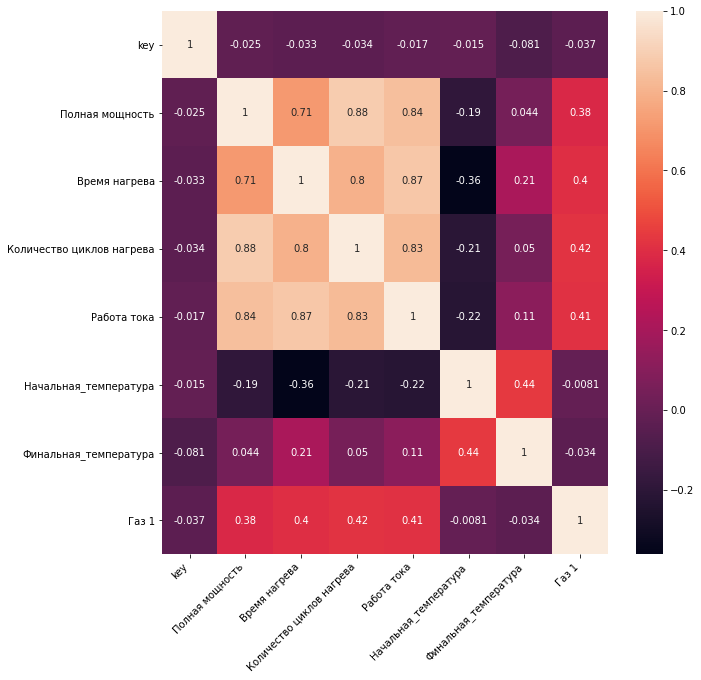

In [47]:
# Вычислим матрицу корреляций для merged_data_arc_temp_gas
corr_matrix_data_arc_temp_gas = merged_data_arc_temp_gas.corr()

# Установим размер поля 10 на 10 дюймов
fig, ax = plt.subplots(figsize=(10, 10))

# Визуализируем матрицу корреляций в виде тепловой карты
heatmap = sns.heatmap(corr_matrix_data_arc_temp_gas, annot=True, ax=ax)

# Поворачиваем названия столбцов на 45 градусов
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

#### Имеются высокие значения корреляции между столбцами:
- Количество циклов нагрева и Полная мощность (0.88), 
- Работа тока и Полная мощность (0.84), 
- Работа тока и Время нагрева (0.87), 
- Работа тока и количество циклов нагрева (0.83) 

В случае, если полученная метрика будет ниже целевого значения, возможно потребуется исключить столбцы с высокой корреляцией из набора данных

In [48]:
# Объедим датафреймы по ключу
merged_data_bulk_wire = pd.merge(data_bulk, data_wire, on='key', how='inner')

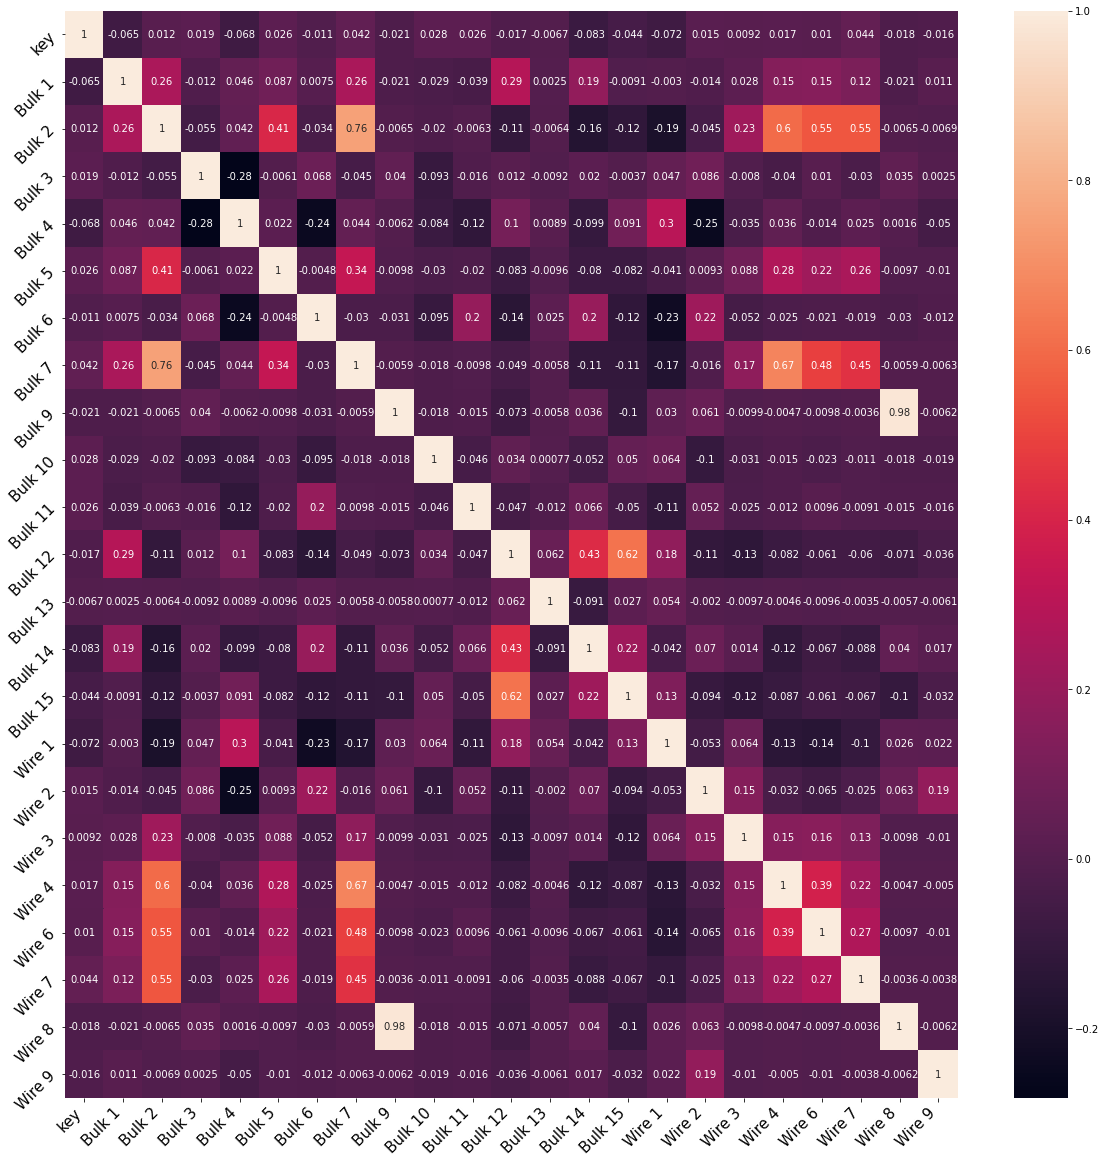

In [49]:
# Вычислим матрицу корреляций для merged_data_bulk_wire
corr_matrix_bulk_wire = merged_data_bulk_wire.corr()

# Установим размер поля 20 на 20 дюймов
fig, ax = plt.subplots(figsize=(20, 20))

# Визуализируем матрицу корреляций в виде тепловой карты
heatmap = sns.heatmap(corr_matrix_bulk_wire, annot=True, ax=ax)

# Поворнём названия столбцов на 45 градусов
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
heatmap.set_yticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')

# Установим размер шрифта
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=15)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=15)

plt.show()

Имеются высокие значения корреляции между столбцами Wire 8 и Bulk 9 (0.98)

Найдем количество не нулевых значений в данных столбцах

In [50]:
merged_data_bulk_wire[(merged_data_bulk_wire['Wire 8'] > 0) & \
                      (merged_data_bulk_wire['Bulk 9'] > 0)].shape

(19, 23)

In [51]:
merged_data_bulk_wire[(merged_data_bulk_wire['Wire 8'] > 0)].shape

(19, 23)

In [52]:
merged_data_bulk_wire[merged_data_bulk_wire['Bulk 9'] > 0].shape

(19, 23)

Добавки Wire 8 и Bulk 9 достаточно редкие (использовались 19 раз) и применяются совместно

In [53]:
# Удалим столбец Bulk 9 для предотвращения мультиколлиниарности
merged_data_bulk_wire = merged_data_bulk_wire.drop(['Bulk 9'], axis=1)

In [54]:
# Объединим датафреймы
data = pd.merge(merged_data_arc_temp_gas, merged_data_bulk_wire, on='key', how='inner')

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   key                        2324 non-null   int64  
 1   Полная мощность            2324 non-null   float64
 2   Время нагрева              2324 non-null   int64  
 3   Количество циклов нагрева  2324 non-null   int64  
 4   Работа тока                2324 non-null   float64
 5   Начальная_температура      2324 non-null   float64
 6   Финальная_температура      2324 non-null   float64
 7   Газ 1                      2324 non-null   float64
 8   Bulk 1                     2324 non-null   float64
 9   Bulk 2                     2324 non-null   float64
 10  Bulk 3                     2324 non-null   float64
 11  Bulk 4                     2324 non-null   float64
 12  Bulk 5                     2324 non-null   float64
 13  Bulk 6                     2324 non-null   float

#### Разделение датафрейма на выборки

In [56]:
# Зафиксируем значение генератора случайных чисел
SEED = 240423

In [57]:
# Признаками будут все столбцы за исключением 'Финальная_температура' и 'key'
features = data.drop(['Финальная_температура','key'], axis=1)
# Столбец 'Финальная_температура' - целевой признак
target = data['Финальная_температура']

In [58]:
# Разделим данные в пропорции 25:75
features_train, features_test, target_train, target_test = train_test_split(features,\
target, test_size=0.25, random_state=SEED)

In [59]:
# Проверка корректности проведенного разделения
print('Размер обучающей выборки features_train -',features_train.shape[0])
print('Размер обучающей выборки target_train   -',target_train.shape[0])
print('Размер тестовой выборки features_test   -',features_test.shape[0])
print('Размер тестовой выборки target_test     -',target_test.shape[0])

Размер обучающей выборки features_train - 1743
Размер обучающей выборки target_train   - 1743
Размер тестовой выборки features_test   - 581
Размер тестовой выборки target_test     - 581


#### Вывод по разделу 6

В разделе 6 была проведена предобработка данных, включающая в себя:
- Удаление из data_temp ключей (партий) с температурой ниже температуры плавления стали (1500 градусов);  
- удаление из data_arc ключей (партий), содержащих отрицательные значения реактивной мощности;  
- Удаление из data_wire и data_bulk встречающиеся однократно добавок Wire5 и Bulk8;  
- Заполнение пропусков в data_wire и data_bulk нулями;  
- Удаление ключей (партий)с пропусками в столбце 'Температура';
- Удаление ключей (партий) с однократным замером температуры;
- Создание в data_arc столбца 'Полная мощность' по формуле $\sqrt{А^2 + Р^2}$;  
- Создание столбца 'Время нагрева' (в секундах);  
- Создание в data_arc столбца с числом циклов нагрева;  
- Создание столбца с работой электрического тока (Дж)('Полная мощность'х'Время нагрева');
- Удаление столбца Bulk 9 для предотвращения мультиколлиниарности.

Объединенный датафрейм содержит столбцы: Полная мощность, Время нагрева, Количество циклов нагрева, Работа тока, Начальная_температура, Финальная_температура, Газ 1, Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15, Wire 1, Wire 2, Wire 3, Wire 4, Wire 6, Wire 7, Wire 8, Wire 9 

Признаками для обучения модели являются все столбцы за исключением 'Финальная_температура' и 'key'. Столбец 'Финальная_температура' - целевой признак.

Данные были разделены в пропорции 25:75 на обучающую и тестовую выборку:  
Размер обучающей выборки features_train - 1743
Размер обучающей выборки target_train   - 1743
Размер тестовой выборки features_test   - 581
Размер тестовой выборки target_test     - 581  

### Обучение моделей

In [60]:
# Параметры кросс-валидации (5 фолдов с перемешиванием) 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

#### LinearRegression()

In [61]:
%%time
# Создадим pipeline, содержащий StandardScaler и LinearRegression
pipe_lr = Pipeline([('scaler', StandardScaler()),
                    ('lr', LinearRegression())])

# Считаем MAE на кросс-валидации
mae_scores_lr = -cross_val_score(pipe_lr, features_train, target_train, cv=skf,
                                 scoring='neg_mean_absolute_error', n_jobs=-1)

# Выводим среднее значение MAE
print('MAE на обучающей выборке для LinearRegression =', round(mae_scores_lr.mean(), 3))

MAE на обучающей выборке для LinearRegression = 6.405
CPU times: user 259 ms, sys: 758 ms, total: 1.02 s
Wall time: 973 ms


Визуализируем важность признаков для LinearRegression() с использованием SHAP. На гистограмме покажем на сколько сильно каждый признак влияет на таргет в среднем по всем объектам обучающей выборки. На данном типе графика рассматриваются только абсолютные SHAP-значения.

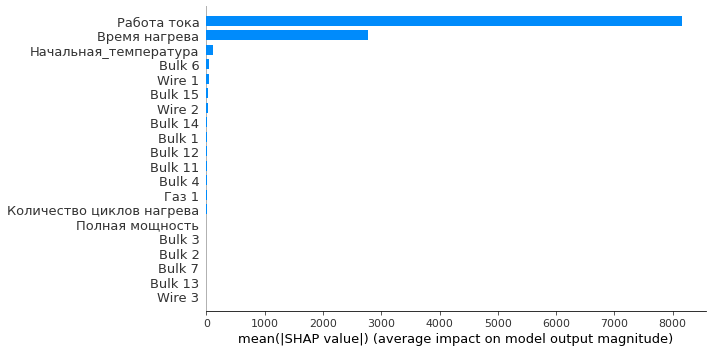

In [62]:
# Обучим модель
pipe_lr.fit(features_train, target_train)

# Создадим explainer
explainer = shap.Explainer(pipe_lr.named_steps['lr'], features_train)

# Вычислим SHAP-значения на обучающей выборке
shap_values = explainer(features_train)

# Визуализируем SHAP-значения
shap.summary_plot(shap_values, features_train, plot_type='bar', plot_size=(10,5))


#### LGBMRegressor()

In [63]:
%%time
# Создадим pipeline, который последовательно применит StandardScaler и LGBMRegressor
pipe_lgb = Pipeline([('scaler', StandardScaler()),
                     ('lgb', LGBMRegressor(n_jobs=-1, random_state=SEED))])

# Создадим сетку гиперпараметров для GridSearchCV
param_grid_lgb = {'lgb__max_depth': [-1, 5],
                  'lgb__n_estimators': [100, 150],
                  'lgb__learning_rate': [0.1, 0.01]}

# Используем GridSearchCV для кросс-валидации
grid_search_lgb = GridSearchCV(pipe_lgb, param_grid=param_grid_lgb, cv=skf,
                               scoring='neg_mean_absolute_error', n_jobs=-1)

# Обучаем модель с помощью GridSearchCV
grid_search_lgb.fit(features_train, target_train)

# Выводим лучшие гиперпараметры и значение MAE на кросс-валидации
print('Лучшие гиперпараметры:', grid_search_lgb.best_params_)
print('MAE на обучающей выборке для LGBMRegressor =', round(-grid_search_lgb.best_score_, 3))

Лучшие гиперпараметры: {'lgb__learning_rate': 0.1, 'lgb__max_depth': 5, 'lgb__n_estimators': 100}
MAE на обучающей выборке для LGBMRegressor = 6.396
CPU times: user 22.9 s, sys: 358 ms, total: 23.2 s
Wall time: 23.7 s


Визуализируем важность признаков для LGBMRegressor() с использованием SHAP. На гистограмме покажем на сколько сильно каждый признак влияет на таргет в среднем по всем объектам обучающей выборки. На данном типе графика рассматриваются только абсолютные SHAP-значения.

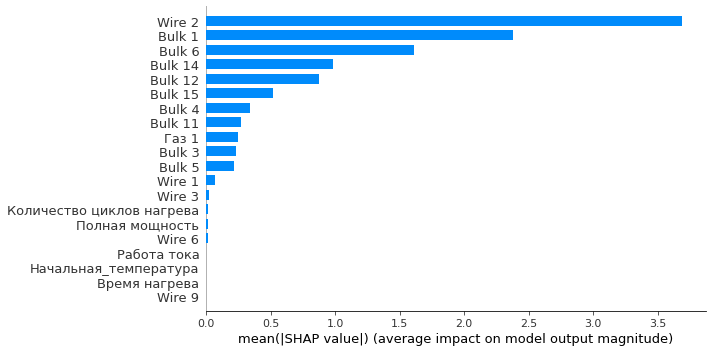

In [64]:
# Создадим pipeline, который последовательно применит StandardScaler и LGBMRegressor
pipe_lgb = Pipeline([('scaler', StandardScaler()),
                     ('lgb', LGBMRegressor(learning_rate=0.1,
                                           max_depth=5,
                                           n_jobs=-1,
                                           n_estimators=100,
                                           random_state=SEED))])
# Обучим модель
pipe_lgb.fit(features_train, target_train)

# Создадим explainer
explainer = shap.Explainer(pipe_lgb.named_steps['lgb'], features_train)

# Вычислим SHAP-значения на обучающей выборке
shap_values = explainer(features_train)

# Визуализируем SHAP-значения
shap.summary_plot(shap_values, features_train, plot_type='bar', plot_size=(10,5))

Выбранные при подготовке плана модели LinearRegression и  LGBMRegressor обеспечили значение MAE, удовлетворяющее требованию заказчика (< 6.8). Попробуем улучшить метрику до значения ниже 6.3. Для этого воспользуемся моделью CatBoostRegressor, не предусмотренной первоначальным планом работы.  

#### CatBoostRegressor

In [65]:
%%time
# Создадим pipeline, который последовательно применяет StandardScaler и CatBoostRegressor
pipe_cat = Pipeline([('scaler', StandardScaler()),
                     ('cat', CatBoostRegressor(random_state=SEED,
                                               verbose=False))])

# Создадим сетку гиперпараметров для GridSearchCV
param_grid_cat = {'cat__depth': [4, 6],
                  'cat__l2_leaf_reg': [10, 15]}

# Используем GridSearchCV для кросс-валидации
grid_search_cat = GridSearchCV(pipe_cat, param_grid=param_grid_cat, cv=skf,
                               scoring='neg_mean_absolute_error', n_jobs=-1)

# Обучаем модель с помощью GridSearchCV
grid_search_cat.fit(features_train, target_train)

# Выводим лучшие гиперпараметры и значение MAE на кросс-валидации
print('Лучшие гиперпараметры:', grid_search_cat.best_params_)
print('MAE на обучающей выборке для CatBoostRegressor =', round(-grid_search_cat.best_score_, 3))

Лучшие гиперпараметры: {'cat__depth': 6, 'cat__l2_leaf_reg': 15}
MAE на обучающей выборке для CatBoostRegressor = 6.2
CPU times: user 45.7 s, sys: 1.31 s, total: 47 s
Wall time: 1min 8s


Визуализируем важность признаков для CatBoostRegressor с использованием SHAP. На гистограмме покажем на сколько сильно каждый признак влияет на таргет в среднем по всем объектам обучающей выборки. На данном типе графика рассматриваются только абсолютные SHAP-значения.

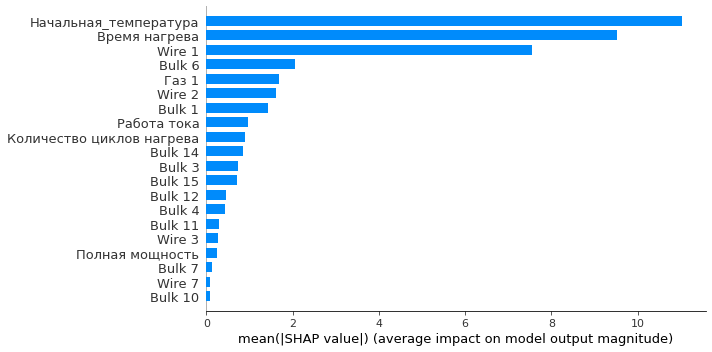

In [66]:
# Создадим pipeline с использованием StandardScaler и лучшей моделью CatBoostRegressor
pipe_cat = Pipeline([('scaler', StandardScaler()),
                     ('cat', CatBoostRegressor(depth=6,
                                               l2_leaf_reg=15,
                                               random_state=SEED,
                                               verbose=False))])
# Обучим модель
pipe_cat.fit(features_train, target_train)

# Значения SHAP на обучающей выборке
shap_values = pipe_cat['cat'].get_feature_importance(Pool(features_train, label=target_train), 
                                                     type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()

# Визуализируем SHAP
shap.summary_plot(shap_values, features_train, plot_type='bar', plot_size=(10,5))

#### Вывод по разделу 7 

В разделе 7 были обучены три модели. С использованием кросс-валидации были определены значения МАЕ на обучающей выборке, а также лучшие значения гиперпараметров для моделей LGBMRegressor, CatBoostRegressor.

Параметры кросс-валидации  - 5 фолдов с перемешиванием.

MAE на обучающей выборке:  
- LinearRegression() = 6.405;  
- LGBMRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=-1, random_state=SEED) = 6.396;  
- CatBoostRegressor(depth=6, l2_leaf_reg=15, random_state=SEED, verbose=False) = 6.2

С помощью SHAP для каждой модели визуализировали важность признаков. Набор наиболее важных признаков отличается в зависимости от выбранной модели:

10 наиболее значимых признаков:
- для модели LinearRegression: 'Работа тока','Время нагрева','Начальная_температура','Bulk 6','Wire 1','Bulk 15','Wire 2','Bulk 14','Bulk 1','Bulk 12'.  
- для модели LGBMRegressor: 'Wire 2','Bulk 1','Bulk 6','Bulk 14','Bulk 12','Bulk 15','Bulk 4','Bulk 11','Газ 1','Bulk 3'.  
- для модели CatBoostRegressor: 'Начальная_температура','Время нагрева','Wire 1','Bulk 6','Газ 1','Wire 2','Bulk 1','Работа тока','Количество циклов нагрева','Bulk 14'.

Все три модели показали на обучающей выборке результат соответствующий требованиям заказчика. Из трёх моделей лучший результат на тестовой выборке показала модель CatBoostRegressor(depth=6, l2_leaf_reg=15, random_state=SEED, verbose=False). Испытаем данную модель в разделе 8 на тестовой выборке.

Для выбранной модели CatBoostRegressor(depth=6, l2_leaf_reg=15, random_state=SEED, verbose=False) построим диаграмму "Водопад" с использованием SHAP.

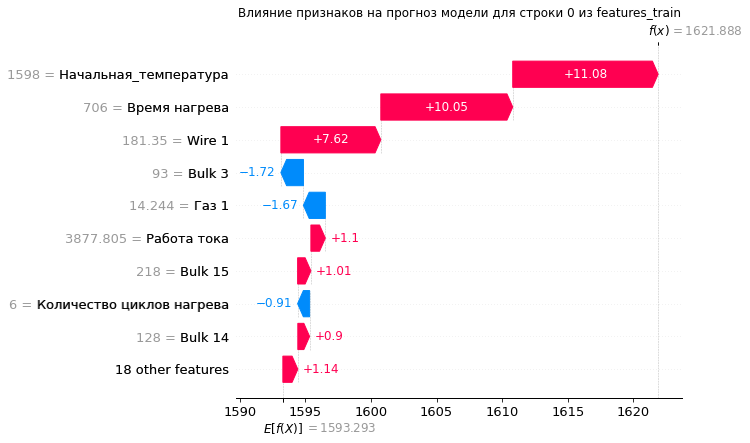

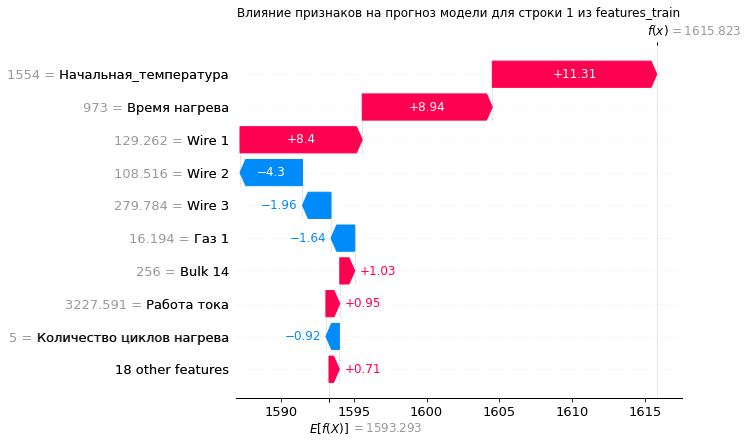

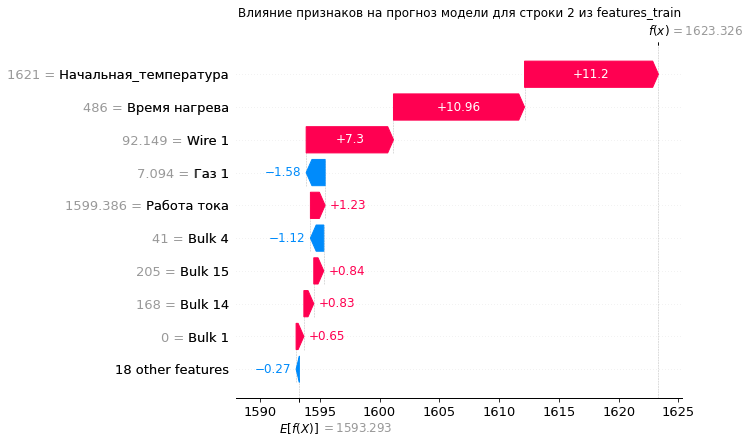

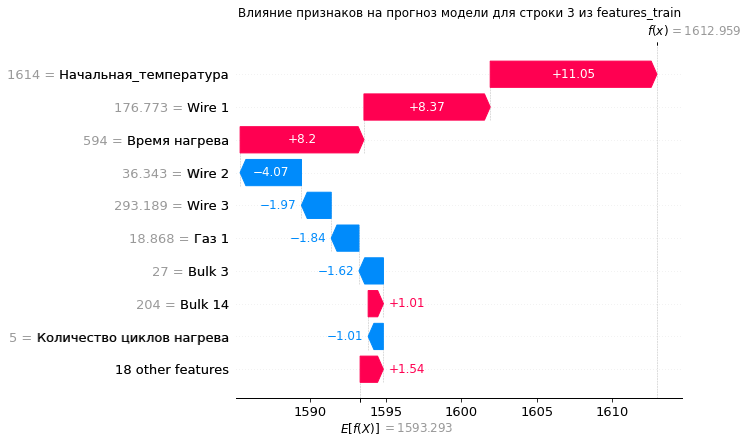

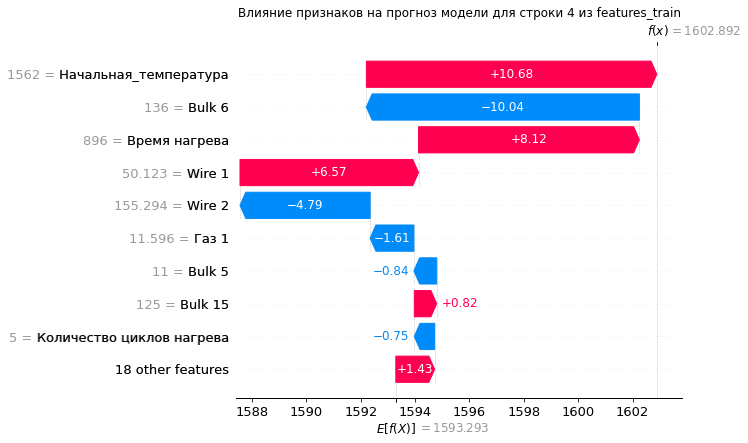

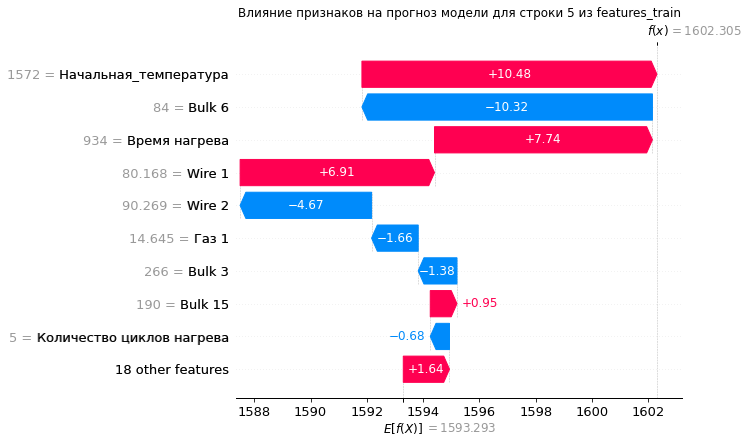

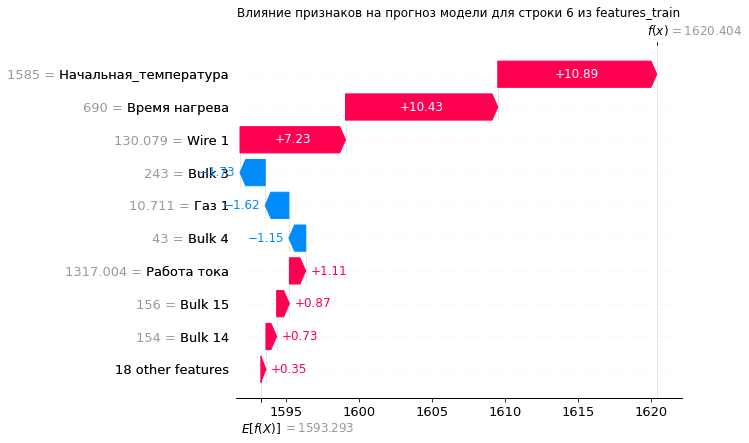

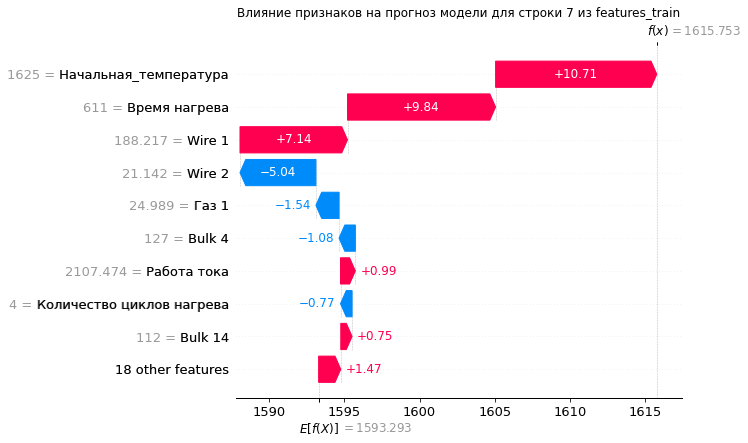

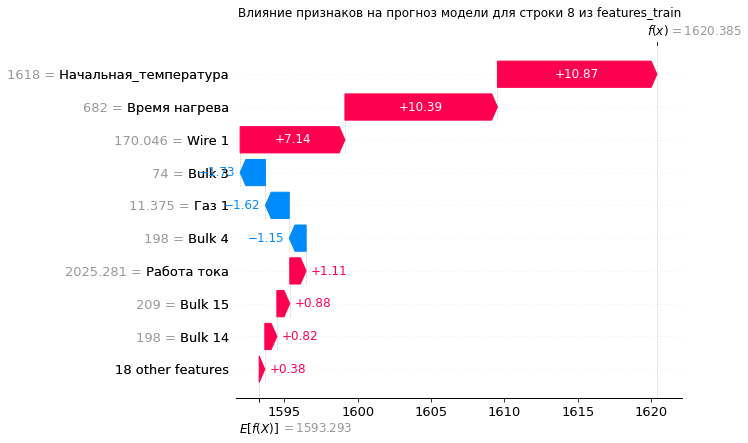

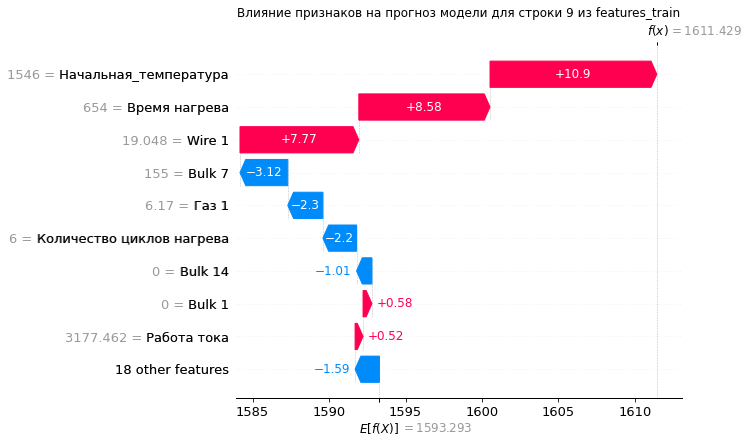

In [67]:
# Построим диаграмму водопада для первых 10 партий из features_train
for i in range(10):
    shap.waterfall_plot(shap.Explanation(values=shap_values[i], base_values=expected_value, data=features_train.iloc[i,:]), show=False)
    plt.title(f'Влияние признаков на прогноз модели для строки {i} из features_train')
    plt.show()

Даграмма водопад позволяет понять, какие признаки наиболее важны для модели и как они влияют на ее предсказания. Знак и значение каждого признака показывает его влияние на таргет.

### Проверка выбранной модели на тестовой выборке

#### Проверка  модели

In [68]:
%%time
# Оценим качество модели на тестовой выборке
predict_cat = pipe_cat.predict(features_test)
mae = mean_absolute_error(target_test, predict_cat)
print('MAE на тестовой выборке для CatBoostRegressor', round(mae, 3))

MAE на тестовой выборке для CatBoostRegressor 5.757
CPU times: user 269 µs, sys: 7.85 ms, total: 8.12 ms
Wall time: 6.58 ms


#### Вывод по разделу 8

Модель CatBoostRegressor(depth=6, l2_leaf_reg=15, random_state=240423, verbose=False) при кросс-валидации на обучающих данных показала значение МАЕ = 6.197. На тестовой выборке результат модели улучшился. Значение МАЕ на тестовой выборке для модели составило 5.757, что соответствует требованиям заказчика

### Общий вывод по второй части проекта

После первичного ознакомления с данными была проведена предобработка данных, включающая в себя:
- Удаление из data_temp ключей (партий) с температурой ниже температуры плавления стали (1500 градусов);
- Удаление из data_arc ключей (партий), содержащих отрицательные значения реактивной мощности;
- Удаление из data_wire и data_bulk встречающиеся однократно добавок Wire5 и Bulk8;
- Заполнение пропусков в data_wire и data_bulk нулями;
- Удаление ключей (партий) с пропусками в столбце 'Температура';
- Удаление ключей (партий) с однократным замером температуры;
- Удаление столбца Bulk 9 для предотвращения мультиколлиниарности.

Были сгенерированы дополнительные признаки:

- Создание в data_arc столбца 'Полная мощность' по формуле  $\sqrt{А^2 + Р^2}$;
- Создание столбца 'Время нагрева' (в секундах);
- Создание в data_arc столбца с числом циклов нагрева;
- Создание столбца с работой электрического тока (Дж)('Полная мощность'х'Время нагрева');

Объединенный датафрейм содержит столбцы: Полная мощность, Время нагрева, Количество циклов нагрева, Работа тока, Начальная_температура, Финальная_температура, Газ 1, Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15, Wire 1, Wire 2, Wire 3, Wire 4, Wire 6, Wire 7, Wire 8, Wire 9

Признаками для обучения модели являются все столбцы за исключением 'Финальная_температура' и 'key'. Столбец 'Финальная_температура' - целевой признак.

Данные были разделены в пропорции 25:75 на обучающую и тестовую выборку:
Размер обучающей выборки features_train - 1746 строк
Размер обучающей выборки target_train - 1746 строк
Размер тестовой выборки features_test - 583 строк
Размер тестовой выборки target_test - 583 строк

Значение генератора случайных чисел, используемое в работе: SEED = 240423

В соответствии с первоначальным планом использовались модели LinearRegression, LGBMRegressor. Выбранные при подготовке плана модели LinearRegression и LGBMRegressor обеспечили значение MAE, удовлетворяющее требованию заказчика (MAE < 6.8). Использование модели CatBoostRegressor, не предусмотренной первоначальным планом работы, позволило улучшить MAE до 6.2 при кросс-валидации на обучающей выборке.

Параметры кросс-валидации - 5 фолдов с перемешиванием.

MAE на обучающей выборке:

- LinearRegression() = 6.405;
- LGBMRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=-1, random_state=SEED) = 6.396;
- CatBoostRegressor(depth=6, l2_leaf_reg=15, random_state=SEED, verbose=False) = 6.2

С помощью SHAP для каждой модели произведена визуализация важности признаков. Набор наиболее важных признаков отличается в зависимости от выбранной модели:

10 наиболее значимых признаков:

- для модели LinearRegression: 'Работа тока','Время нагрева','Начальная_температура','Bulk 6','Wire 1','Bulk 15','Wire 2','Bulk 14','Bulk 1','Bulk 12'.
- для модели LGBMRegressor: 'Wire 2','Bulk 1','Bulk 6','Bulk 14','Bulk 12','Bulk 15','Bulk 4','Bulk 11','Газ 1','Bulk 3'.
- для модели CatBoostRegressor: 'Начальная_температура','Время нагрева','Wire 1','Bulk 6','Газ 1','Wire 2','Bulk 1','Работа тока','Количество циклов нагрева','Bulk 14'.

Все три модели показали на обучающей выборке результат соответствующий требованиям заказчика. Из трёх моделей лучший результат на тестовой выборке показала модель CatBoostRegressor(depth=6, l2_leaf_reg=15, random_state=SEED, verbose=False).

Для выбранной модели CatBoostRegressor была построена даграмма водопад, позволяющая определить, какие признаки наиболее важны для модели и как они влияют на ее предсказания.

Модель CatBoostRegressor(depth=6, l2_leaf_reg=15, random_state=240423, verbose=False) при кросс-валидации на обучающих данных показала значение МАЕ = 6.197. **На тестовой выборке результат модели улучшился. Значение МАЕ на тестовой выборке для модели составило 5.757**, что соответствует требованиям заказчика

_________________________

### Отчёт о проекте Data Science: построение ML модели для предсказания температуры стали на металлургическом комбинате

#### Описание задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

##### Описание технологического процесса

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

##### Описание данны

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Данные доступны для загрузки по следующим ссылкам:  
https://code.s3.yandex.net/datasets/data_arc_new.csv  
https://code.s3.yandex.net/datasets/data_bulk_new.csv  
https://code.s3.yandex.net/datasets/data_bulk_time_new.csv  
https://code.s3.yandex.net/datasets/data_gas_new.csv  
https://code.s3.yandex.net/datasets/data_temp_new.csv  
https://code.s3.yandex.net/datasets/data_wire_new.csv  
https://code.s3.yandex.net/datasets/data_wire_time_new.csv  

#### Область применения

С помощью модели возможно осуществлять имитацию технологического процесса. Модель позволяет воспроизводить процесс выплавки стали и впоследующем тестировать на практике только лучшие результаты. Модель позволяет выделить наиболее важные признаки, влияющие на нагрев и конечную температуру сплава

#### Персонал команды

Проект выполнен командой специалистов по Data Science:  
Сергей Волков - специалист по Data Science (тимлид);  
Илья Шувалов - специалист по Data Science.  

#### Показатели

Качество полученной модели машинного обучения будет оцениваться на тестовом наборе данных. Качество определяется путём определения средней абсолютной ошибки (MAE - mean absolute error). Минимальное значение МАЕ для признания модели успешной и подходящей для развёртывания составляет 6.8 градусов цельсия

#### План работы над построением модели

1. Провести первичное ознакомление с данными
2. Провести исследовательский анализ данных
3. Провести предобработку данных (удалить аномалии, заполнить пропуски в данных)
4. Определить признаки, которые будут необходимы для построения модели
5. Создать датафрейм, содержащий все необходимые призаки и таргеты
6. Осуществить разделение данных на обучающую и тестовую выборку
7. Провести масштабирование данных
8. Планирую использование моделей LinearRegression, LightGBM
9. Подобрать параметры LightGBM с помощью кросс-валидации
10. Выбрать модель, показавшую лучшее значение метрики на обучающих данных
11. Протестировать выбранную модель на тестовом наборе

#### Информация о выполнении плана

**В результате ознакомления с данными и проведенного исследовательского анализа установлено следующее.**

- Средняя активная мощность подаваемая на электроды составляет 0.662752 МВт, Средняя реактивная мощность составляет 0.438986 МВар. Имеются значительные отрицательные значения по Реактивной мощности - выбросы в данных. 
- Средняя длительность потребления мощности электродами составляет 171 секунду, минимальное значение - 11 секунд, максимальное значение - 907 секунд.
- Существует сильная линейная зависимость между активной и реактивной мощностью.
- Значение объема сыпучего материала в столбце 'bulk 8' встречаются в наборе данных data_bulk однократно и равно 49. Реже всего применяются сыпучие материалы: Bulk 8 - 1 раз, Bulk 13 - 18 раз, Bulk 9 - 19 раз, Bulk 2 - 22 раза, Bulk 7 - 25 раз, Bulk 5 - 77 раз.
- В наборе данных data_temp содержаться данные с пониженной температурой сплава (около 1200 градусов) относительно медианного значения - 1600 градусов.
- Значение объема проволочного материала в столбце 'Wire 5' в data_wire встречаются в наборе данных однократно и равно 15.132 Реже всего применяются проволочные материалы: Wire 5 - 1 раз, Wire 7 - 11 раз, Wire 4 - 14 раз, Wire 9 - 29 раз, Wire 3 - 63 раз, Wire 5 - 73 раза.
- Наиболее частыми являются добавки проволочных материалов Wire 1 - 3055 раз, Wire 2 - 1079 раз.

**Проведена предобработка данных, включающая в себя:**
- Удаление из data_temp ключей (партий) с температурой ниже температуры плавления стали (1500 градусов);  
- удаление из data_arc ключей (партий), содержащих отрицательные значения реактивной мощности;  
- Удаление из data_wire и data_bulk встречающиеся однократно добавок Wire5 и Bulk8;  
- Заполнение пропусков в data_wire и data_bulk нулями;  
- Удаление ключей (партий)с пропусками в столбце 'Температура';
- Удаление ключей (партий) с однократным замером температуры;
- Создание в data_arc столбца 'Полная мощность' по формуле $\sqrt{А^2 + Р^2}$;  
- Создание столбца 'Время нагрева' (в секундах);  
- Создание в data_arc столбца с числом циклов нагрева;  
- Создание столбца с работой электрического тока (Дж)('Полная мощность'х'Время нагрева');
- Удаление столбца Bulk 9 для предотвращения мультиколлиниарности.

**Признаки для обучения модели**  
Полная мощность, Время нагрева, Количество циклов нагрева, Работа тока, Начальная_температура, Газ 1, Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15, Wire 1, Wire 2, Wire 3, Wire 4, Wire 6, Wire 7, Wire 8, Wire 9.

**целевой признак**  
Финальная_температура.  

**Разделение данных на выборки**   
Данные были разделены в пропорции 25:75 на обучающую и тестовую выборку:  
Размер обучающей выборки features_train - 1743
Размер обучающей выборки target_train   - 1743
Размер тестовой выборки features_test   - 581
Размер тестовой выборки target_test     - 581 

Далее, на полученных данных мы обучили три модели. С использованием кросс-валидации были определены значения МАЕ на обучающей выборке, а также лучшие значения гиперпараметров для моделей LGBMRegressor, CatBoostRegressor.

**Параметры применяемой кросс-валидации**  - 5 фолдов с перемешиванием.

**Масштабирование данных** - осуществлялось в Pipeline с использованием StandardScaler().

**MAE на обучающей выборке:**  
- LinearRegression() = 6.405;  
- LGBMRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=-1, random_state=SEED) = 6.396;  
- CatBoostRegressor(depth=6, l2_leaf_reg=15, random_state=SEED, verbose=False) = 6.2

Все три модели показали на обучающей выборке результат соответствующий минимальным требованиям. Из трёх моделей лучший результат на тестовой выборке показала модель CatBoostRegressor(depth=6, l2_leaf_reg=15, random_state=SEED, verbose=False). 

**ТОП-10 наиболее значимых признаков для модели  CatBoostRegressor(depth=6, l2_leaf_reg=15, random_state=SEED, verbose=False):**  
'Начальная_температура','Время нагрева','Wire 1','Bulk 6','Газ 1','Wire 2','Bulk 1','Работа тока','Количество циклов нагрева','Bulk 14'. 
                                                                               
**Значение МАЕ  на тестовой выборке**  
Для выбранной модели CatBoostRegressor(depth=6, l2_leaf_reg=15, random_state=240423, verbose=False) МАЕ составило 5.757, что является хорошим показателем качества модели

#### Сложности возникшие при выполнении плана

Выбранные при подготовке плана модели LinearRegression и LGBMRegressor обеспечили значение MAE, удовлетворяющее требованию заказчика (< 6.8). Но качество данных моделей машинного обучения не опускалось менее 6.3. В связи с чем пришлось отклониться от первоначального плана и применить модель  CatBoostRegressor(depth=6, l2_leaf_reg=15, random_state=240423, verbose=False). Применение данной модели позволило получить на тестовой выборке МАЕ 5.757 градусов, что является лучшим из полученных результатов.